In [1]:
import numpy as np  
import pandas as pd  
import matplotlib.pyplot as plt 
from torch.nn.utils import prune
from copy import deepcopy
from sklearn.preprocessing import RobustScaler 
import torch
import random
from torch import nn
plt.rc("font",family="SimHei",size="15") 

%matplotlib inline 

In [2]:
pip install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu121

# data setting


In [2]:

train = pd.read_csv("data2/X_train.csv")
test = pd.read_csv("data2/X_test.csv")

X_train = train.drop("SalePrice",axis=1)
X_test = test.drop("SalePrice",axis=1)

y_train = train["SalePrice"]
y_test= test["SalePrice"]

In [3]:
torch.cuda.is_available()

True

In [4]:
torch.cuda.is_available()
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

In [5]:
X_train.head()

,MSSubClass,LotFrontage,LotArea,Street,LotShape,LandSlope,OverallQual,OverallCond,YearBuilt,YearRemodAdd,...,SaleType_ConLw,SaleType_New,SaleType_Oth,SaleType_WD,SaleCondition_Abnorml,SaleCondition_AdjLand,SaleCondition_Alloca,SaleCondition_Family,SaleCondition_Normal,SaleCondition_Partial
0,1.8,0.454545,-0.191453,0.0,0.0,0.0,0.0,2.0,-0.187500,-0.815789,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,-1.0,0.0
1,0.0,0.000000,-0.289205,0.0,0.0,0.0,-0.5,0.0,0.729167,0.342105,...,0.0,1.0,0.0,-1.0,0.0,0.0,0.0,0.0,-1.0,1.0
2,0.0,0.136364,-0.218961,0.0,0.0,0.0,0.5,0.0,0.687500,0.289474,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.409091,0.174260,0.0,0.0,0.0,-0.5,2.0,-0.145833,-0.763158,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.318182,0.105735,0.0,0.0,1.0,-0.5,0.0,0.041667,-0.500000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [6]:
x_in = torch.Tensor(X_train.values).to(device).to(torch.float32)
x_val = torch.Tensor(X_test.values).to(device).to(torch.float32)

y_in = torch.Tensor(y_train.values).to(device).to(torch.float32)
y_val = torch.Tensor(y_test.values).to(device).to(torch.float32)

scaler = RobustScaler()
y_train_s = scaler.fit_transform(y_train.array.reshape(-1, 1))
y_in_s = torch.Tensor(y_train_s).to(device).to(torch.float32)
y_test_s = scaler.transform(y_test.array.reshape(-1, 1))
y_val_s = torch.Tensor(y_test_s).to(device).to(torch.float32)


In [30]:
#Xavier initialization
def init_weights(m, k=1, gain=10):
    for i in m:
        if isinstance(i, nn.Linear):
            nn.init.xavier_normal_(i.weight, gain=gain)
            i.bias.data.fill_(k)

#l2 reguliaztion
def l2_loss(model, lambda0 = 0.001):
    paras = []
    for para in model.parameters():
        paras.append(para.view(-1))
    return lambda0* torch.square(torch.cat(paras)).sum()
#set DO and BN layer
def DO_BN(model,DO:bool,BN:bool):
    dropout_probs = [ 0.1,0.1,0.1]
    for name, module in model.named_modules():
        if isinstance(module, nn.Dropout):
            module.p =  dropout_probs.pop(0) if DO else 0
        if isinstance(module, nn.BatchNorm1d) or isinstance(module, nn.BatchNorm2d):
            module.track_running_stats = BN

def forward(model,x = x_in,y = y_in_s,l2=False):
    try:
        y_pred = model(x)
    except:
        print(x)
        print(model)
        print(type(model))
        print(model[0])
        print("unexpected error")

    loss = nn.functional.mse_loss(y_pred,y).to(device)
    if l2:
        loss+=  l2_loss(model)
    return loss
    






In [8]:
#trian process
def training(model,EB = True, LG = False,UA= False, DO = False, BN = False, l2 = True,
             regulization = True,initial_lr = 1e-3, stopping_lr = 6e-5, stopping_error = 0.05 , stopping_epochs = 75, verbose = True):
    #set old model to output_model when running regulization
    if regulization:
        #output_model = deepcopy(model)
        output_model = model
    else:
        init_weights(model,0.1,1)
        
   #activate DO and BNlayer or not
    DO_BN(model,DO,BN)
    # Disable tracking running statistics
    if UA and DO: print("Warning: Some error may occur for DO+ReduceLROnPlateau scheduler. Consider changing to CosineAnnealingLR scheduler.")
    #set Adam to be optimizer 
    optimizer = torch.optim.Adam(model.parameters(), lr=initial_lr)

    #set learning scheduler
    lr_scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.8, patience=10,verbose=True,
                                                              cooldown=10, min_lr=0, eps=1e-05)
    epochs = 0
    loss_in_list = []
    loss_out_list = []
    while True:
        #forward
        epochs += 1
        model.eval()# 切換到評估模式
        loss_out = forward(model,x_val,y_val_s,l2)

        model.train()  # 切換到訓練模式
        loss_in = forward(model,x_in,y_in_s,l2)
  
        #store loss values
        loss_in_list.append(loss_in.item())
        loss_out_list.append(loss_out.item())
        
        #check LG critiria
        if (loss_in < stopping_error) & LG:    
            if verbose: print("LG stop")
            break      

        #backward
        optimizer.zero_grad()
        loss_in.backward()
        optimizer.step()
        #check UA critiria
        lr_scheduler.step(loss_in)
        current_lr = optimizer.param_groups[0]['lr']
        if verbose: print(f'Epoch {epochs}: Loss In {loss_in.item()}, Loss Out {loss_out.item()}, Learning Rate {current_lr}')
        if  UA :
            for param_group in optimizer.param_groups:
                    param_group['lr'] *= 1.02
            if (current_lr<stopping_lr) :
                if verbose: print('UA stop')
                break
        if regulization:
            output_model = model
            #print("Fail to copy the model")
            if verbose: print('update new model')                 

        #check EB critiria
        if (epochs >= stopping_epochs) & EB:
            if verbose: print("EB stop")
            if regulization:
                if ~UA and ~LG and (loss_in < stopping_error):
                    output_model = model
                    if verbose: print('new model accept')
                else:
                    if verbose: print("unacceptable model")
            break


    if verbose: print(f'Training finished in {epochs} epochs.')
    
    if regulization:
        return loss_in_list,loss_out_list,stopping_error, output_model
    return loss_in_list, loss_out_list, stopping_error


In [9]:
#plot errors
def draw_lr_step(loss_in_list,loss_out_list,stopping_error):
    # Assuming you have the epoch numbers as a list
    epoch_list = list(range(1, len(loss_in_list)+1))

    # Assuming you have the lists for loss_in and loss_out

    plt.figure(figsize=(10, 6))
    plt.plot(epoch_list, loss_in_list, label='Loss In')
    plt.plot(epoch_list, loss_out_list, label='Loss Out')
    plt.axhline(y=stopping_error, color='gray', linestyle='--',
                linewidth=1.5, label='Stopping Value = '+str(stopping_error))
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Loss of LG weight tuning')
    plt.legend()
    plt.ylim(0, 1)
    plt.scatter(epoch_list[-1], loss_out_list[-1], color='red', s=100, label='Last Point out')
    plt.text(epoch_list[-1], loss_out_list[-1]+0.03, f'  {loss_out_list[-1]:.4f}', verticalalignment='bottom', horizontalalignment='right', color='red')
    plt.scatter(epoch_list[-1], loss_in_list[-1], color='red', s=100, label='Last Point in')
    plt.text(epoch_list[-1], loss_in_list[-1]+0.03, f'  {loss_in_list[-1]:.4f}', verticalalignment='bottom', horizontalalignment='right', color='red')
    plt.grid(True)
    plt.show()


In [33]:
def draw_pred_reggsion(model,print_error = True):
    model.eval()
    y_pred_val_s = model(x_val)
    loss1 = nn.functional.mse_loss(y_pred_val_s,y_val_s)
    y_pred_val = torch.Tensor(scaler.inverse_transform(torch.Tensor.cpu(y_pred_val_s).detach().numpy()))
    loss2 = nn.functional.mse_loss(y_pred_val,torch.Tensor.cpu(y_val))
    if print_error:
        print(torch.Tensor.cpu(loss1).tolist())
        print(torch.Tensor.cpu(loss2).tolist())
        

    y_pred_val_list = y_pred_val.tolist()
    y_val_list = y_val.tolist()
    # Perform linear regression
    slope, intercept = np.polyfit(np.array(y_pred_val_list).flatten(), np.array(y_val_list).flatten(), 1)

    plt.figure(figsize=(10, 6))
    plt.plot(y_pred_val_list, y_val_list, 'o', label='Data points')
    plt.plot(y_pred_val_list, np.array(y_pred_val_list) * slope + intercept, '-', label='Regression line')
    plt.xlabel('Prediction')
    plt.ylabel('House Price')
    plt.title('Regression line between Prediction and House Price')
    plt.legend()
    plt.grid(True)
    plt.show()



In [76]:
def mask_node(layer,i, unmask = False):
        mask = layer.weight_mask if hasattr(layer, 'weight_mask') else torch.ones(layer.weight.shape, device=layer.weight.device)
        mask[i,: ] = 1  if unmask else  0
        #layer.register_buffer('weight_mask', mask )
        prune.custom_from_mask(layer, name='weight', mask=mask)

def find_linear(model,last = False):
        linear_id = []
        for i,layer in enumerate(model.children()):
                if isinstance(layer, nn.Linear): linear_id.append(i)
        if not last: linear_id .pop()
        return  linear_id 


def min_weight_order(linear_layer):
    # 取得權重張量
    weight_tensor = linear_layer.weight.detach().cpu().numpy()
    #print(np.abs(weight_tensor ))
    
    # 計算每個隱藏節點的最小絕對值權重
    min_abs_weights = np.min(np.abs(weight_tensor), axis=1)
    #print(len(min_abs_weights))
    #print("min_abs_weights",min_abs_weights)
    
    # 根據最小絕對值權重從小到大進行排序
    sorted_indices = np.argsort(min_abs_weights).tolist()
    print(sorted_indices)

    #ignore masked nodes
    if hasattr(linear_layer, 'weight_mask'):
        mask_index = np.where(linear_layer.weight_mask.cpu().numpy()[:, 0] == 0)[0].tolist()
        #print("mask_index:", mask_index)
        sorted_indices = [i for i in sorted_indices if i not in mask_index]
        #print("filtered sorted_indices:", sorted_indices)
    return sorted_indices

def prune_node_1234(model ,tolerance = 0,type = 1):
        origin_loss = forward(model)
        error_bound = origin_loss + tolerance
        linear_id = find_linear(model)
        out_model = deepcopy(model)

        for layer_id in linear_id :
                #if i == len(model)-1: break
                
                layer = out_model[layer_id]
                p = layer.weight.shape[0]
                node_order=  list(range(p))
                #print(node_order)
                
                fail = 0
                for j in node_order:
                        k = j 
                        if type ==3: k =  random.randint(1,p)
                        if type ==4: k =  min_weight_order(layer)[0]

                        mask_node(layer,k)
                        loss_new = forward(out_model)
                        if type != 1:  training(out_model, l2 = False,regulization = True,stopping_epochs = 75,stopping_error=error_bound,verbose=False)
                        print("Pruning layer",layer_id,  "node",k ,", error_bound = ",round(error_bound.item(),4), "loss_new = ", round(loss_new.item(),4))
                        if loss_new  <= error_bound:
                                print("node",k," is removed")
                        else:
                                mask_node(layer,k,unmask = True)      
                                fail=fail+1 
                        if type ==3 or  type == 4:
                               if fail>=3: 
                                        print("fail>3")
                                        break 
                        #print(fail)
                prune.remove(layer, "weight")   
        return out_model


        

## Best Model: 11 hidden  with RELU act

N, D_in,  D_out = 978, 214, 1
p = [ 0.1,0.3,0.3]

model_11 = nn.Sequential(
    nn.Linear(D_in, 100),
    nn.BatchNorm1d(100, track_running_stats=False),  # BatchNorm1d after the linear layer, not activate
    nn.LeakyReLU(),
    nn.Dropout(p=0),  # Dropout
    nn.Linear(100, 50),
    nn.BatchNorm1d(50, track_running_stats=False),  # BatchNorm1d after the linear layer, not activate
    nn.LeakyReLU(),
    nn.Dropout(p=0),  # Dropout
    nn.Linear(50, 11),
    nn.BatchNorm1d(11, track_running_stats=False),  # BatchNorm1d after the linear layer, not activate
    nn.LeakyReLU(),
    nn.Dropout(p=0),  # Dropout
    nn.Linear(11, D_out)
)
if torch.cuda.is_available():
    model_11.cuda()
    
models_EB_accept = []
models_EB_regulization = []

In [82]:
N, D_in,  D_out = 978, 214, 1
p = [ 0.1,0.3,0.3]

model_11 = nn.Sequential(
    nn.Linear(214,100),
    nn.BatchNorm1d(100, track_running_stats=False),  # BatchNorm1d after the linear layer, not activate
    nn.LeakyReLU(),
    nn.Dropout(p=0),  # Dropout
    nn.Linear(100, D_out)
)
if torch.cuda.is_available():
    model_11.cuda()
    
models_EB_accept = []
models_EB_regulization = []

### 0.1 weight tuning EB  + pruning 1

In [83]:
EB = True
LG = False
UA= False
DO = False
BN = False
l2 = False
regulization = False
initial_lr = 1e-3
stopping_lr = 6e-4
stopping_error = 0.15 if l2 else 0.15
stopping_epochs = 100

loss_in_list, loss_out_list, stopping_error = training(model_11,EB = EB, LG = LG,UA= UA, DO = DO, BN = BN, l2 = l2,
             regulization = regulization,initial_lr = initial_lr, stopping_lr = stopping_lr, stopping_error = stopping_error, stopping_epochs = stopping_epochs)
  
models_EB_accept.append(model_11)

Epoch 1: Loss In 2.5319440364837646, Loss Out 2.6739842891693115, Learning Rate 0.001
Epoch 2: Loss In 2.204801559448242, Loss Out 2.3150734901428223, Learning Rate 0.001
Epoch 3: Loss In 1.915522813796997, Loss Out 2.0060150623321533, Learning Rate 0.001
Epoch 4: Loss In 1.66328763961792, Loss Out 1.7429711818695068, Learning Rate 0.001
Epoch 5: Loss In 1.4486868381500244, Loss Out 1.5310213565826416, Learning Rate 0.001
Epoch 6: Loss In 1.2727545499801636, Loss Out 1.375709056854248, Learning Rate 0.001
Epoch 7: Loss In 1.1291730403900146, Loss Out 1.2674368619918823, Learning Rate 0.001
Epoch 8: Loss In 1.0157381296157837, Loss Out 1.1839137077331543, Learning Rate 0.001
Epoch 9: Loss In 0.9292598366737366, Loss Out 1.121263027191162, Learning Rate 0.001
Epoch 10: Loss In 0.86211097240448, Loss Out 1.0794280767440796, Learning Rate 0.001
Epoch 11: Loss In 0.8134276270866394, Loss Out 1.0517756938934326, Learning Rate 0.001
Epoch 12: Loss In 0.7796993851661682, Loss Out 1.03495526313

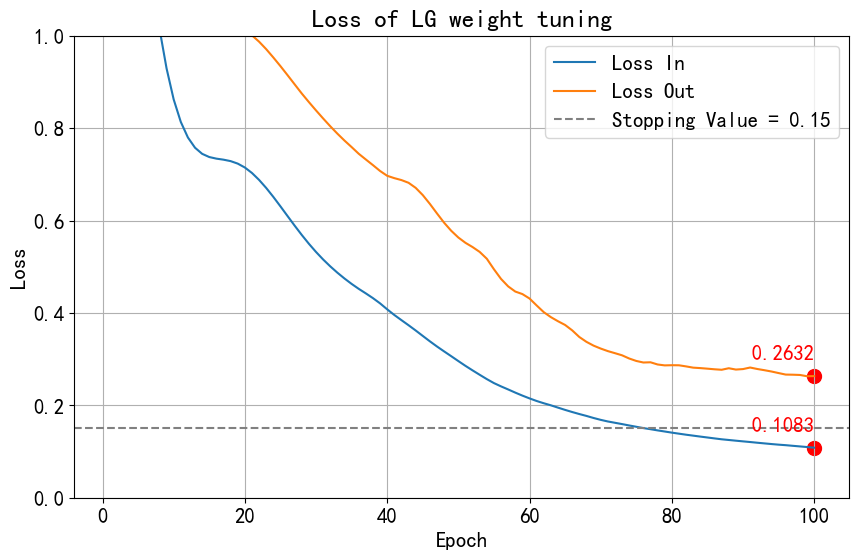

In [84]:
draw_lr_step(loss_in_list,loss_out_list,stopping_error)

0.26544511318206787
10819749888.0


C:\Users\IanKu\AppData\Local\Temp\ipykernel_22612\2668975548.py:6: UserWarning: Using a target size (torch.Size([482])) that is different to the input size (torch.Size([482, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  loss2 = nn.functional.mse_loss(y_pred_val,torch.Tensor.cpu(y_val))


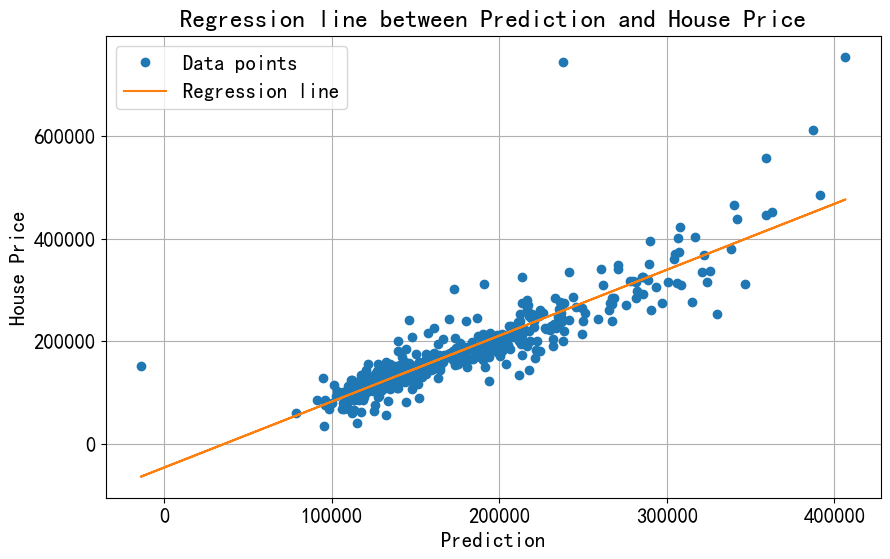

In [85]:
draw_pred_reggsion(model_11,print_error = True)

In [86]:
new_model = prune_node_1234(model_11, type=1)

Pruning layer 0 node 0 , error_bound =  0.1071 loss_new =  0.1271
Pruning layer 0 node 1 , error_bound =  0.1071 loss_new =  0.1877
Pruning layer 0 node 2 , error_bound =  0.1071 loss_new =  0.1114
Pruning layer 0 node 3 , error_bound =  0.1071 loss_new =  0.1962
Pruning layer 0 node 4 , error_bound =  0.1071 loss_new =  0.127
Pruning layer 0 node 5 , error_bound =  0.1071 loss_new =  0.1073
Pruning layer 0 node 6 , error_bound =  0.1071 loss_new =  0.1112
Pruning layer 0 node 7 , error_bound =  0.1071 loss_new =  0.1118
Pruning layer 0 node 8 , error_bound =  0.1071 loss_new =  0.1291
Pruning layer 0 node 9 , error_bound =  0.1071 loss_new =  0.1075
Pruning layer 0 node 10 , error_bound =  0.1071 loss_new =  0.1071
Pruning layer 0 node 11 , error_bound =  0.1071 loss_new =  0.1087
Pruning layer 0 node 12 , error_bound =  0.1071 loss_new =  0.1077
Pruning layer 0 node 13 , error_bound =  0.1071 loss_new =  0.1078
Pruning layer 0 node 14 , error_bound =  0.1071 loss_new =  0.1191
Prunin

C:\Users\IanKu\AppData\Local\Temp\ipykernel_22612\2668975548.py:6: UserWarning: Using a target size (torch.Size([482])) that is different to the input size (torch.Size([482, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  loss2 = nn.functional.mse_loss(y_pred_val,torch.Tensor.cpu(y_val))
c:\Users\IanKu\anaconda3\Lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 8722 (\N{MINUS SIGN}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


0.26655852794647217
10806183936.0


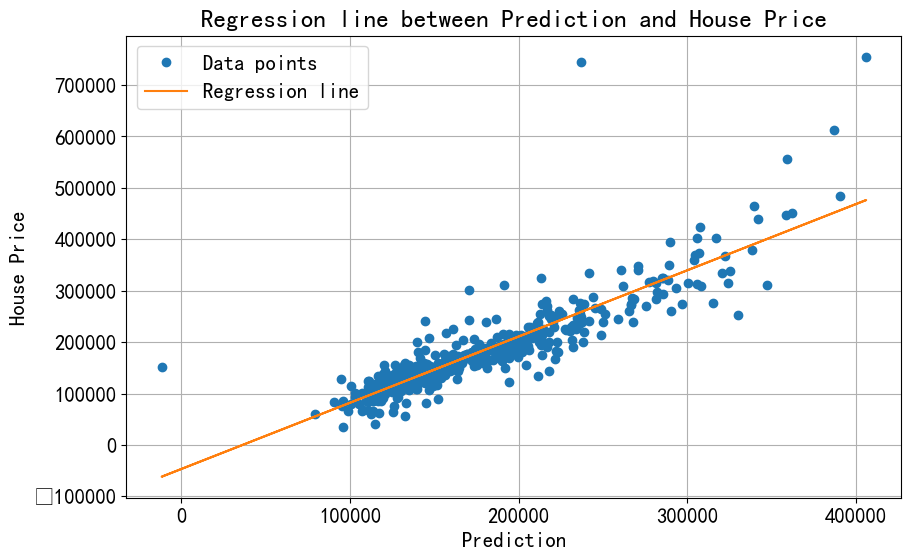

In [88]:
draw_pred_reggsion(new_model,print_error = True)

### 0.2 weight tuning EB  + pruning 2

In [89]:
N, D_in,  D_out = 978, 214, 1
p = [ 0.1,0.3,0.3]

model_11 = nn.Sequential(
    nn.Linear(214, 100),
    nn.BatchNorm1d(100, track_running_stats=False),  # BatchNorm1d after the linear layer, not activate
    nn.LeakyReLU(),
    nn.Dropout(p=0),  # Dropout
    nn.Linear(100, D_out)
)
if torch.cuda.is_available():
    model_11.cuda()
    
models_EB_accept = []
models_EB_regulization = []

In [90]:
EB = True
LG = False
UA= False
DO = False
BN = False
l2 = False
regulization = False
initial_lr = 1e-3
stopping_lr = 6e-4
stopping_error = 0.15 if l2 else 0.15
stopping_epochs = 100

loss_in_list, loss_out_list, stopping_error = training(model_11,EB = EB, LG = LG,UA= UA, DO = DO, BN = BN, l2 = l2,
             regulization = regulization,initial_lr = initial_lr, stopping_lr = stopping_lr, stopping_error = stopping_error, stopping_epochs = stopping_epochs)
  
models_EB_accept.append(model_11)

Epoch 1: Loss In 1.9223095178604126, Loss Out 2.3414382934570312, Learning Rate 0.001
Epoch 2: Loss In 1.6706790924072266, Loss Out 2.0413732528686523, Learning Rate 0.001
Epoch 3: Loss In 1.450504183769226, Loss Out 1.7792606353759766, Learning Rate 0.001
Epoch 4: Loss In 1.2654036283493042, Loss Out 1.575636386871338, Learning Rate 0.001
Epoch 5: Loss In 1.114188313484192, Loss Out 1.4048993587493896, Learning Rate 0.001
Epoch 6: Loss In 0.9910486936569214, Loss Out 1.2601662874221802, Learning Rate 0.001
Epoch 7: Loss In 0.8953285217285156, Loss Out 1.1419569253921509, Learning Rate 0.001
Epoch 8: Loss In 0.8247085213661194, Loss Out 1.051870346069336, Learning Rate 0.001
Epoch 9: Loss In 0.7738714814186096, Loss Out 0.9935485124588013, Learning Rate 0.001
Epoch 10: Loss In 0.7392405867576599, Loss Out 0.9509406089782715, Learning Rate 0.001
Epoch 11: Loss In 0.71706622838974, Loss Out 0.921811580657959, Learning Rate 0.001
Epoch 12: Loss In 0.703712522983551, Loss Out 0.90340924263

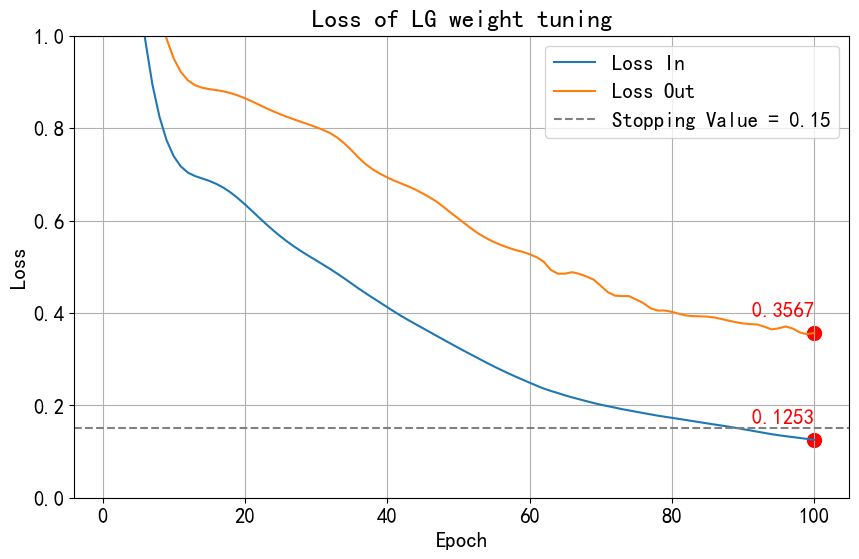

In [91]:
draw_lr_step(loss_in_list,loss_out_list,stopping_error)

C:\Users\IanKu\AppData\Local\Temp\ipykernel_22612\2668975548.py:6: UserWarning: Using a target size (torch.Size([482])) that is different to the input size (torch.Size([482, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  loss2 = nn.functional.mse_loss(y_pred_val,torch.Tensor.cpu(y_val))


0.35356053709983826
10590697472.0


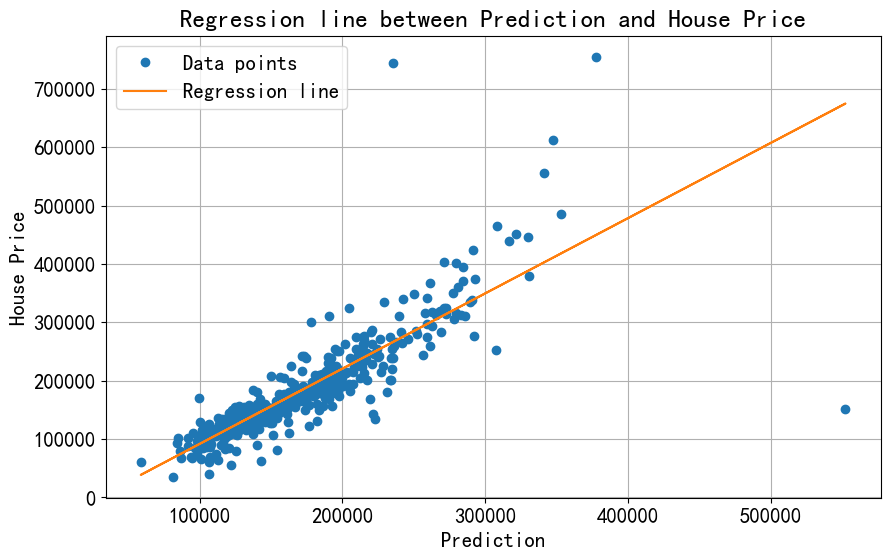

In [92]:
draw_pred_reggsion(model_11,print_error = True)

In [93]:
print(model_11)

Sequential(
  (0): Linear(in_features=214, out_features=100, bias=True)
  (1): BatchNorm1d(100, eps=1e-05, momentum=0.1, affine=True, track_running_stats=False)
  (2): LeakyReLU(negative_slope=0.01)
  (3): Dropout(p=0, inplace=False)
  (4): Linear(in_features=100, out_features=1, bias=True)
)


In [94]:
new_model = prune_node_1234(model_11,type=2)

Pruning layer 0 node 0 , error_bound =  0.1233 loss_new =  0.1249
Pruning layer 0 node 1 , error_bound =  0.1233 loss_new =  0.0685
node 1  is removed
Epoch 00012: reducing learning rate of group 0 to 8.0000e-04.
Pruning layer 0 node 2 , error_bound =  0.1233 loss_new =  0.0321
node 2  is removed
Epoch 00012: reducing learning rate of group 0 to 8.0000e-04.
Epoch 00033: reducing learning rate of group 0 to 6.4000e-04.
Pruning layer 0 node 3 , error_bound =  0.1233 loss_new =  0.0234
node 3  is removed
Pruning layer 0 node 4 , error_bound =  0.1233 loss_new =  0.0317
node 4  is removed
Pruning layer 0 node 5 , error_bound =  0.1233 loss_new =  0.0237
node 5  is removed
Epoch 00012: reducing learning rate of group 0 to 8.0000e-04.
Epoch 00033: reducing learning rate of group 0 to 6.4000e-04.
Pruning layer 0 node 6 , error_bound =  0.1233 loss_new =  0.0133
node 6  is removed
Epoch 00012: reducing learning rate of group 0 to 8.0000e-04.
Epoch 00033: reducing learning rate of group 0 to 6.

C:\Users\IanKu\AppData\Local\Temp\ipykernel_22612\2668975548.py:6: UserWarning: Using a target size (torch.Size([482])) that is different to the input size (torch.Size([482, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  loss2 = nn.functional.mse_loss(y_pred_val,torch.Tensor.cpu(y_val))


0.35356053709983826
10590697472.0


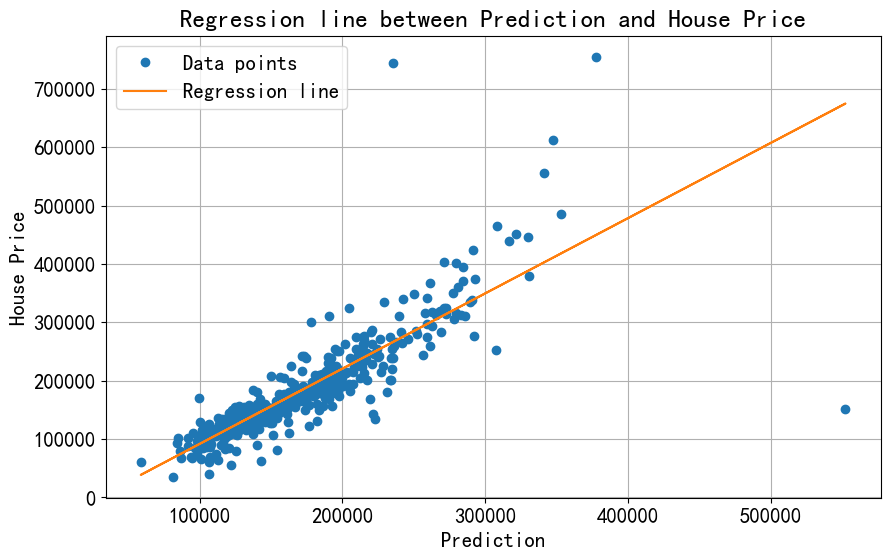

C:\Users\IanKu\AppData\Local\Temp\ipykernel_22612\2668975548.py:6: UserWarning: Using a target size (torch.Size([482])) that is different to the input size (torch.Size([482, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  loss2 = nn.functional.mse_loss(y_pred_val,torch.Tensor.cpu(y_val))


0.20879463851451874
12309881856.0


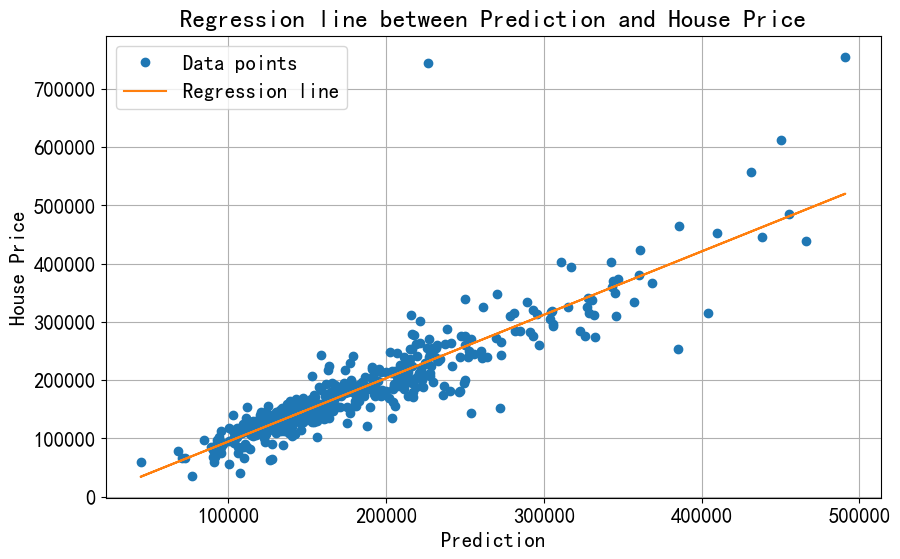

In [96]:
draw_pred_reggsion(model_11,print_error = True)
draw_pred_reggsion(new_model,print_error = True)

### 0.3. weight tuning EB  + Node pruning 3


In [97]:
N, D_in,  D_out = 978, 214, 1
p = [ 0.1,0.3,0.3]

model_11 = nn.Sequential(
    nn.Linear(214, 100),
    nn.BatchNorm1d(100, track_running_stats=False),  # BatchNorm1d after the linear layer, not activate
    nn.LeakyReLU(),
    nn.Dropout(p=0),  # Dropout
    nn.Linear(100, D_out)
)
if torch.cuda.is_available():
    model_11.cuda()
    
models_EB_accept = []
models_EB_regulization = []

In [98]:
EB = True
LG = False
UA= False
DO = False
BN = False
l2 = False
regulization = False
initial_lr = 1e-3
stopping_lr = 6e-4
stopping_error = 0.15 if l2 else 0.15
stopping_epochs = 100

loss_in_list, loss_out_list, stopping_error = training(model_11,EB = EB, LG = LG,UA= UA, DO = DO, BN = BN, l2 = l2,
             regulization = regulization,initial_lr = initial_lr, stopping_lr = stopping_lr, stopping_error = stopping_error, stopping_epochs = stopping_epochs)
  
models_EB_accept.append(model_11)

Epoch 1: Loss In 1.7443971633911133, Loss Out 2.391632556915283, Learning Rate 0.001
Epoch 2: Loss In 1.5252243280410767, Loss Out 2.13430118560791, Learning Rate 0.001
Epoch 3: Loss In 1.3341631889343262, Loss Out 1.9025287628173828, Learning Rate 0.001
Epoch 4: Loss In 1.1715784072875977, Loss Out 1.6977519989013672, Learning Rate 0.001
Epoch 5: Loss In 1.0370290279388428, Loss Out 1.5202600955963135, Learning Rate 0.001
Epoch 6: Loss In 0.9287625551223755, Loss Out 1.3696603775024414, Learning Rate 0.001
Epoch 7: Loss In 0.8455143570899963, Loss Out 1.2469768524169922, Learning Rate 0.001
Epoch 8: Loss In 0.7849110960960388, Loss Out 1.1533606052398682, Learning Rate 0.001
Epoch 9: Loss In 0.7447490692138672, Loss Out 1.0767022371292114, Learning Rate 0.001
Epoch 10: Loss In 0.721186637878418, Loss Out 1.0194742679595947, Learning Rate 0.001
Epoch 11: Loss In 0.7112075686454773, Loss Out 0.9794570207595825, Learning Rate 0.001
Epoch 12: Loss In 0.7107877731323242, Loss Out 0.9537745

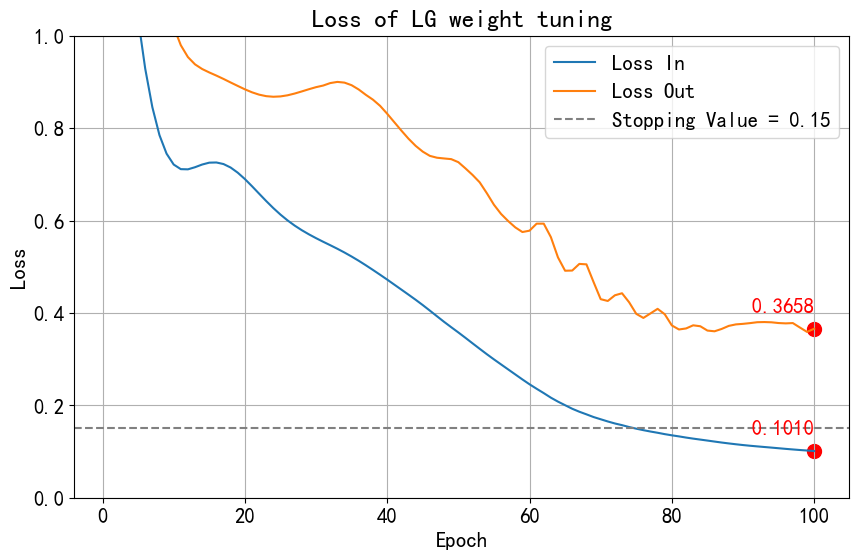

In [99]:
draw_lr_step(loss_in_list,loss_out_list,stopping_error)

In [100]:
new_model = prune_node_1234(model_11,type=3)

Pruning layer 0 node 81 , error_bound =  0.1 loss_new =  0.1161
Pruning layer 0 node 28 , error_bound =  0.1 loss_new =  0.1089
Pruning layer 0 node 52 , error_bound =  0.1 loss_new =  0.0464
node 52  is removed
Epoch 00012: reducing learning rate of group 0 to 8.0000e-04.
Pruning layer 0 node 12 , error_bound =  0.1 loss_new =  0.0288
node 12  is removed
Pruning layer 0 node 86 , error_bound =  0.1 loss_new =  0.025
node 86  is removed
Pruning layer 0 node 13 , error_bound =  0.1 loss_new =  0.0281
node 13  is removed
Epoch 00012: reducing learning rate of group 0 to 8.0000e-04.
Pruning layer 0 node 57 , error_bound =  0.1 loss_new =  0.0167
node 57  is removed
Epoch 00012: reducing learning rate of group 0 to 8.0000e-04.
Pruning layer 0 node 61 , error_bound =  0.1 loss_new =  0.0121
node 61  is removed
Epoch 00012: reducing learning rate of group 0 to 8.0000e-04.
Pruning layer 0 node 7 , error_bound =  0.1 loss_new =  0.012
node 7  is removed
Pruning layer 0 node 56 , error_bound = 

0.3739299476146698
11060789248.0


C:\Users\IanKu\AppData\Local\Temp\ipykernel_22612\2668975548.py:6: UserWarning: Using a target size (torch.Size([482])) that is different to the input size (torch.Size([482, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  loss2 = nn.functional.mse_loss(y_pred_val,torch.Tensor.cpu(y_val))


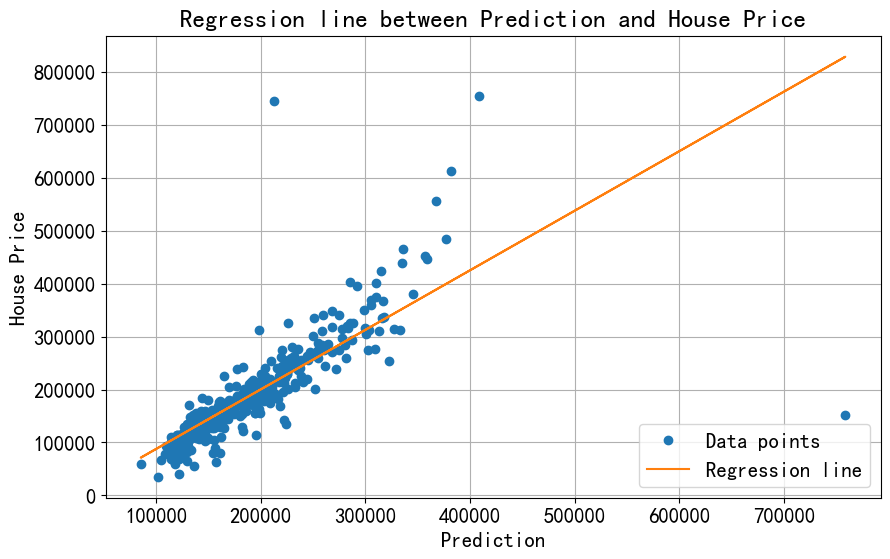

C:\Users\IanKu\AppData\Local\Temp\ipykernel_22612\2668975548.py:6: UserWarning: Using a target size (torch.Size([482])) that is different to the input size (torch.Size([482, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  loss2 = nn.functional.mse_loss(y_pred_val,torch.Tensor.cpu(y_val))


0.2750971019268036
11221059584.0


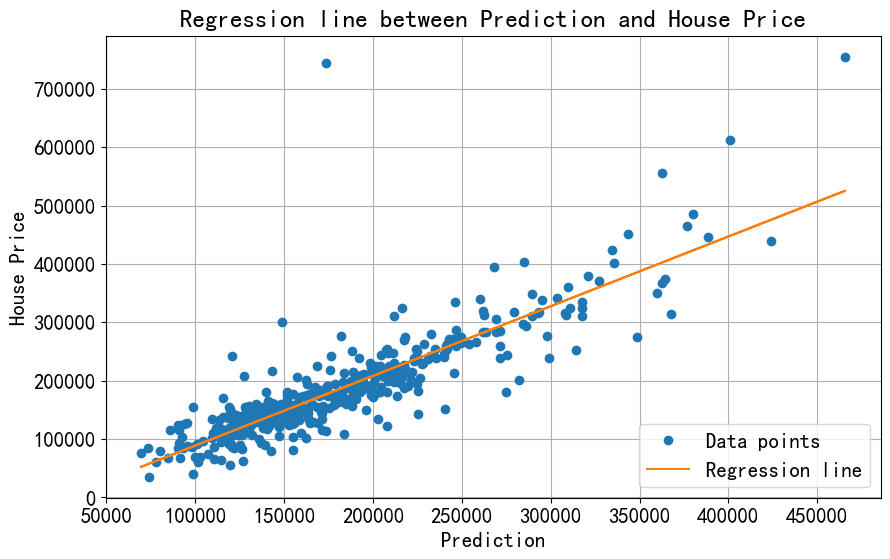

In [101]:
draw_pred_reggsion(model_11,print_error = True)
draw_pred_reggsion(new_model,print_error = True)

### 0.4. weight tuning EB  + pruning 4

In [102]:
N, D_in,  D_out = 978, 214, 1
p = [ 0.1,0.3,0.3]

model_11 = nn.Sequential(
    nn.Linear(214, 100),
    nn.BatchNorm1d(100, track_running_stats=False),  # BatchNorm1d after the linear layer, not activate
    nn.LeakyReLU(),
    nn.Dropout(p=0),  # Dropout
    nn.Linear(100, D_out)
)
if torch.cuda.is_available():
    model_11.cuda()
    
models_EB_accept = []
models_EB_regulization = []
EB = True
LG = False
UA= False
DO = False
BN = False
l2 = False
regulization = False
initial_lr = 1e-3
stopping_lr = 6e-4
stopping_error = 0.15 if l2 else 0.15
stopping_epochs = 100

loss_in_list, loss_out_list, stopping_error = training(model_11,EB = EB, LG = LG,UA= UA, DO = DO, BN = BN, l2 = l2,
             regulization = regulization,initial_lr = initial_lr, stopping_lr = stopping_lr, stopping_error = stopping_error, stopping_epochs = stopping_epochs)
  
models_EB_accept.append(model_11)

Epoch 1: Loss In 2.0188724994659424, Loss Out 2.376116991043091, Learning Rate 0.001
Epoch 2: Loss In 1.8073452711105347, Loss Out 2.1463003158569336, Learning Rate 0.001
Epoch 3: Loss In 1.6158148050308228, Loss Out 1.9410789012908936, Learning Rate 0.001
Epoch 4: Loss In 1.443703293800354, Loss Out 1.764662742614746, Learning Rate 0.001
Epoch 5: Loss In 1.2907682657241821, Loss Out 1.6071208715438843, Learning Rate 0.001
Epoch 6: Loss In 1.1588972806930542, Loss Out 1.4680861234664917, Learning Rate 0.001
Epoch 7: Loss In 1.0452570915222168, Loss Out 1.3469210863113403, Learning Rate 0.001
Epoch 8: Loss In 0.9488114714622498, Loss Out 1.2428025007247925, Learning Rate 0.001
Epoch 9: Loss In 0.8687571883201599, Loss Out 1.153659462928772, Learning Rate 0.001
Epoch 10: Loss In 0.8036395311355591, Loss Out 1.0783785581588745, Learning Rate 0.001
Epoch 11: Loss In 0.751891553401947, Loss Out 1.0178313255310059, Learning Rate 0.001
Epoch 12: Loss In 0.713146984577179, Loss Out 0.970977187

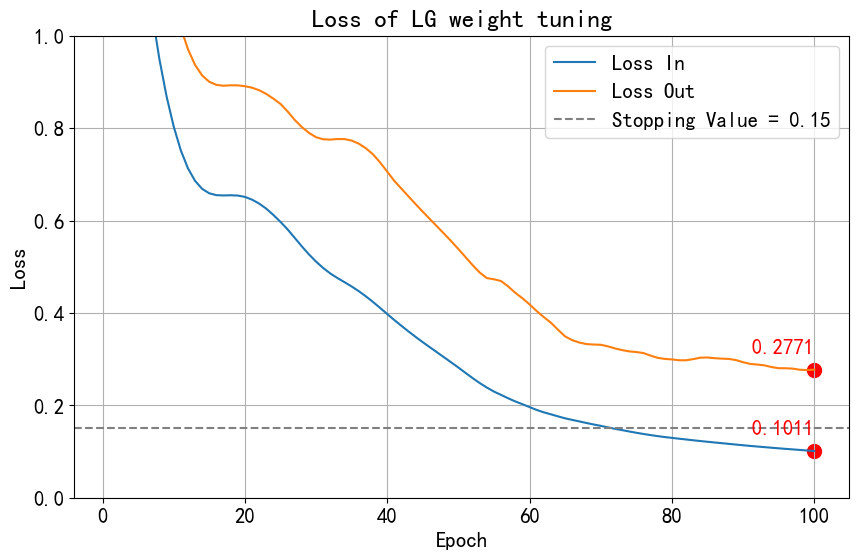

In [103]:
draw_lr_step(loss_in_list,loss_out_list,stopping_error)

In [104]:
new_model = prune_node_1234(model_11,type=4)

[88, 25, 1, 58, 21, 80, 44, 43, 69, 76, 39, 48, 71, 85, 9, 4, 33, 29, 30, 14, 92, 59, 27, 79, 15, 36, 75, 31, 90, 3, 72, 34, 16, 45, 74, 64, 11, 94, 67, 26, 97, 32, 82, 84, 8, 95, 68, 53, 46, 99, 93, 54, 65, 81, 12, 23, 52, 89, 86, 56, 83, 78, 49, 66, 10, 19, 17, 42, 2, 22, 61, 24, 38, 37, 57, 47, 77, 35, 28, 98, 18, 40, 41, 70, 60, 6, 87, 51, 96, 55, 63, 62, 50, 20, 13, 0, 91, 7, 73, 5]
Pruning layer 0 node 88 , error_bound =  0.1 loss_new =  0.1004
[59, 38, 32, 56, 91, 25, 88, 96, 66, 9, 97, 98, 63, 6, 39, 83, 34, 85, 67, 74, 55, 52, 48, 58, 70, 5, 41, 11, 76, 86, 46, 73, 57, 77, 31, 72, 44, 17, 51, 45, 69, 36, 99, 30, 12, 79, 43, 22, 10, 84, 0, 7, 80, 40, 19, 33, 89, 16, 82, 71, 37, 49, 81, 53, 20, 1, 75, 90, 65, 61, 14, 95, 21, 13, 18, 92, 23, 29, 68, 54, 27, 42, 3, 47, 26, 15, 60, 28, 64, 87, 24, 50, 8, 93, 2, 78, 94, 35, 62, 4]
Epoch 00012: reducing learning rate of group 0 to 8.0000e-04.
Pruning layer 0 node 59 , error_bound =  0.1 loss_new =  0.0464
node 59  is removed
[59, 41,

0.27677321434020996
10658421760.0


C:\Users\IanKu\AppData\Local\Temp\ipykernel_22612\2668975548.py:6: UserWarning: Using a target size (torch.Size([482])) that is different to the input size (torch.Size([482, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  loss2 = nn.functional.mse_loss(y_pred_val,torch.Tensor.cpu(y_val))


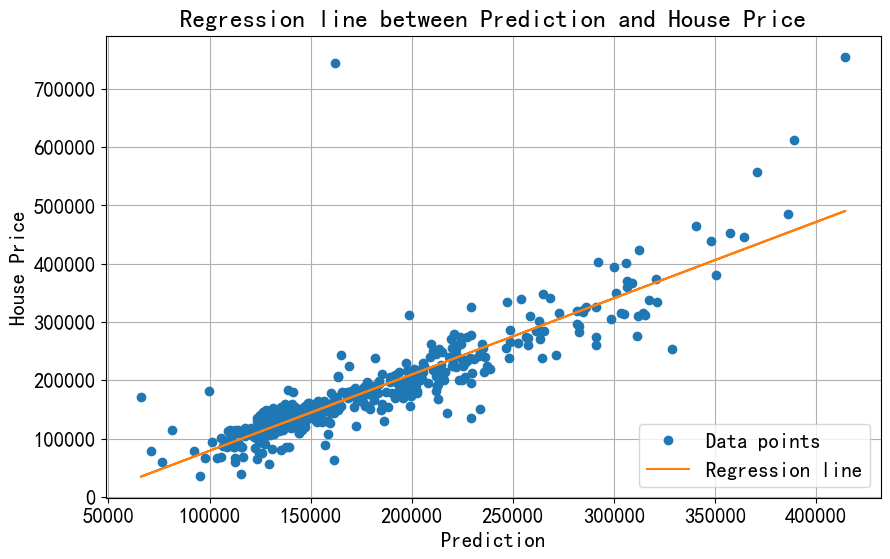

0.28788208961486816
11053776896.0


C:\Users\IanKu\AppData\Local\Temp\ipykernel_22612\2668975548.py:6: UserWarning: Using a target size (torch.Size([482])) that is different to the input size (torch.Size([482, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  loss2 = nn.functional.mse_loss(y_pred_val,torch.Tensor.cpu(y_val))


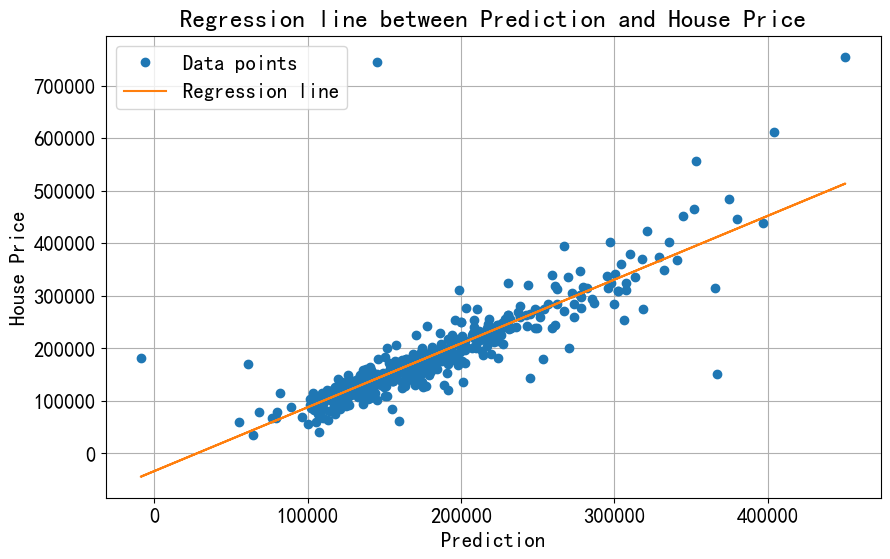

In [105]:
draw_pred_reggsion(model_11,print_error = True)
draw_pred_reggsion(new_model,print_error = True)

## Conclusion

#### HW5Update
#### 這次pruning花了許多時間和精力研究pytorch pruning 的工具以及 weight、parameters、buffer等等的差別，學到了如何直接調整weight以及其他參數。一開始我以為prune.remove是用來隱藏節點的，但後來是拜了好幾次研究好久才發現是讓mask永久化用的。
#### 我們pruning 使用mask 的方式，利用buffer裡的weight mask來去除隱藏節點，但這個方法在pruning4的時候遇到了一些問題，在判定最小值的時候會讀到先前被mask的節點，所以又花了一些時間才刻出來，很報前這麼晚才交><。

#### HW5Update 
#### 1.這次把程式整個大改，把訓練與regulization分開，並且寫成一個訓練的函數，可以選擇是否要EB、LG、UA、DO、BN以及調整訓練模式與regulization模式，雖然最後的code在LG+UA的地方和老師有些差異(老師的LG判定放在迴圈最後，我把LG放在forward後面)，但結果看下來是好的。
#### 2.將訓練與regulization分開後，訓練成本大幅下降，從原本50000步左右變成大約75步，應該是因為加上l2後損失函數圖形變得太複雜，以及沒有l2的話超過75步後容易overfitting導致。一開始把l2丟掉時沒有發現overfitting，等到後來發現model 有訓練模式與評估模式，才發現超級大過擬。
#### 3.小問題，DO layer加上去後拿來做UA的ReduceLROnPlateau就失效了，不管loss 多大lr就是不會變，網路上也找不到相關的議題，可能需要跟老師憶起研究一下。

##### HW3Update 這次加上了顯卡支援跑到了大約50000 epochs 左右，效果也稍微有提升，我發現torch 套件的 torch.optim.lr_scheduler 的 ReduceLROnPlateau 就是在做UA的部分

##### HW2update 這次一開始調了一堆參數增加了好幾層但最後結果都不太理想，後來發現一個問題是我Xavier函數沒寫好，幾乎等於沒做，補好之後發現生出來的數字可以調整scale。另一點模型表現增加最多的地方是對y做了scale，用robust scaler 調整並用來訓練，訓練完後再把test 預測出來的結果用inverse_transform轉換回去。

## hidden nodes:
#### 6 layer 改成 4layer  214 100 50 11 1 
## initial weight:
#### Xavier 
## Activation:
#### 主要用LeakyRELU
## Loss:
#### MSE ,把 l2 regulization 去掉後從50000步降到75步...
## Optmizer epoch
#### Adam 
## learning_rate
#### 起始值設10^-3, UA停止值設 6^10-4, 用ReduceLROnPlateau做UA learn rate decay, loss > 0.1時 lr大概在10^-6 上下，到10^-7左右時跑的超慢
## learn rate scheduler
#### 用ReduceLROnPlateau做UA, 每次變成0.9倍, loss 5輪沒降才會調, 停止值設 6^10-4
## DO
#### 每層被丟掉ˋ的機率都是0.1
## BN
#### 做的是BatchNorm1d，不確定和BatchNorm2d有什麼差別
## Ensembles
#### 下次一定做



### 1. weight tuning EB  + regularizing_EB with l2  loss 

#### train with EB

In [193]:
EB = True
LG = False
UA= False
DO = False
BN = False
l2 = False
regulization = False
initial_lr = 1e-3
stopping_lr = 6e-4
stopping_error = 0.15 if l2 else 0.15
stopping_epochs = 200

loss_in_list, loss_out_list, stopping_error = training(model_11,EB = EB, LG = LG,UA= UA, DO = DO, BN = BN, l2 = l2,
             regulization = regulization,initial_lr = initial_lr, stopping_lr = stopping_lr, stopping_error = stopping_error, stopping_epochs = stopping_epochs)
  
models_EB_accept.append(model_11)



1
Epoch 1: Loss In 1.8116519451141357, Loss Out 1.9406987428665161, Learning Rate 0.001
Epoch 2: Loss In 1.6381860971450806, Loss Out 1.7905691862106323, Learning Rate 0.001
Epoch 3: Loss In 1.4885741472244263, Loss Out 1.6660276651382446, Learning Rate 0.001
Epoch 4: Loss In 1.3584226369857788, Loss Out 1.5615339279174805, Learning Rate 0.001
Epoch 5: Loss In 1.2459222078323364, Loss Out 1.4753527641296387, Learning Rate 0.001
Epoch 6: Loss In 1.1488943099975586, Loss Out 1.4040988683700562, Learning Rate 0.001
Epoch 7: Loss In 1.0654324293136597, Loss Out 1.344665765762329, Learning Rate 0.001
Epoch 8: Loss In 0.9941428899765015, Loss Out 1.294636845588684, Learning Rate 0.001
Epoch 9: Loss In 0.9339551329612732, Loss Out 1.252285122871399, Learning Rate 0.001
Epoch 10: Loss In 0.8839607834815979, Loss Out 1.2161955833435059, Learning Rate 0.001
Epoch 11: Loss In 0.8431823253631592, Loss Out 1.1856069564819336, Learning Rate 0.001
Epoch 12: Loss In 0.8105829358100891, Loss Out 1.1600

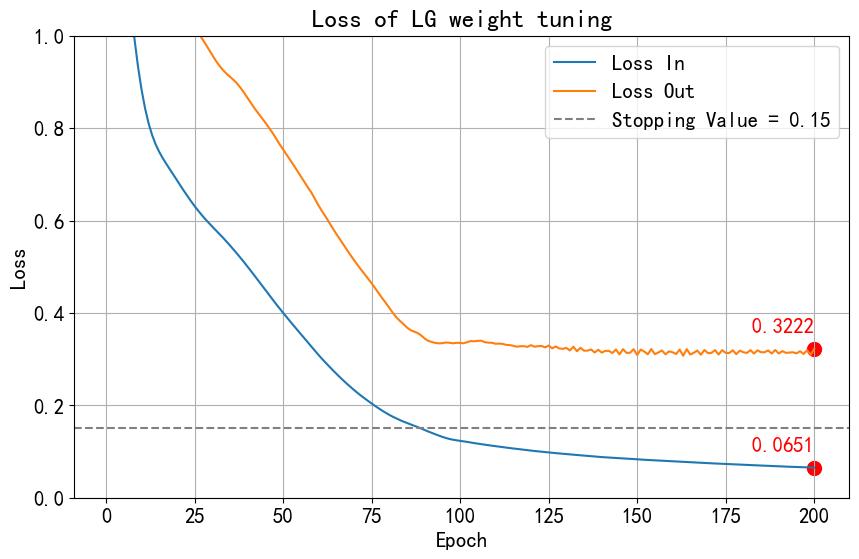

In [198]:
draw_lr_step(loss_in_list,loss_out_list,stopping_error)

0.2504953444004059
10930652160.0


C:\Users\IanKu\AppData\Local\Temp\ipykernel_33068\2668975548.py:6: UserWarning: Using a target size (torch.Size([482])) that is different to the input size (torch.Size([482, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  loss2 = nn.functional.mse_loss(y_pred_val,torch.Tensor.cpu(y_val))


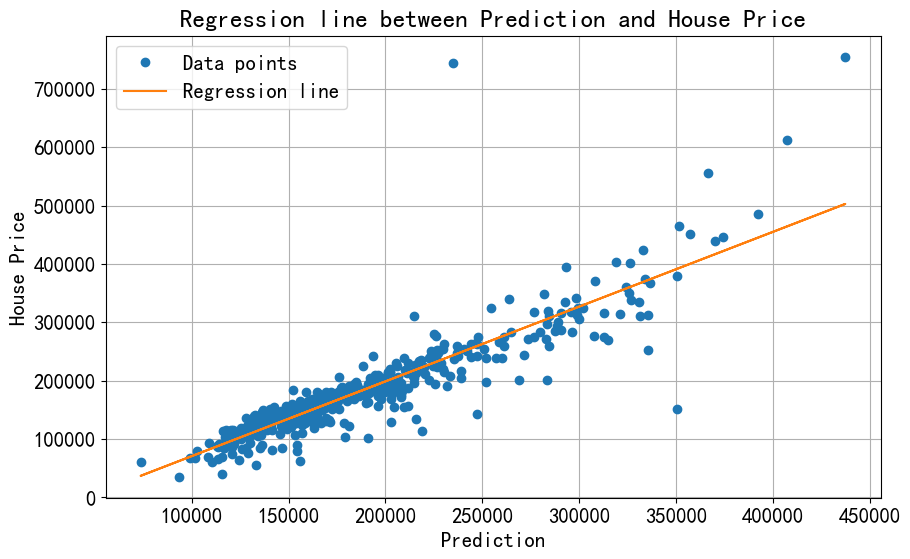

In [199]:
draw_pred_reggsion(model_11,print_error = True)

#### regulization with EB l2

In [203]:
EB = True
LG = False
UA= False
DO = False
BN = False
l2 = True
regulization = True
initial_lr = 1e-1
stopping_lr = 6e-4
stopping_error = 0.15 if l2 else 0.15
stopping_epochs = 75

loss_in_list, loss_out_list, stopping_error, model_11 = training(model_11,EB = EB, LG = LG,UA= UA, DO = DO, BN = BN, l2 = l2,
             regulization = regulization,initial_lr = initial_lr, stopping_lr = stopping_lr, stopping_error = stopping_error, stopping_epochs = stopping_epochs)
  
models_EB_regulization.append(model_11)

Epoch 1: Loss In 0.30530762672424316, Loss Out 0.6165698766708374, Learning Rate 0.1
update new model
Epoch 2: Loss In 26.020366668701172, Loss Out 24.705516815185547, Learning Rate 0.1
update new model
Epoch 3: Loss In 2.169240951538086, Loss Out 2.8003149032592773, Learning Rate 0.1
update new model
Epoch 4: Loss In 4.292140483856201, Loss Out 3.695906162261963, Learning Rate 0.1
update new model
Epoch 5: Loss In 8.232933044433594, Loss Out 7.607024192810059, Learning Rate 0.1
update new model
Epoch 6: Loss In 6.911642551422119, Loss Out 6.880134105682373, Learning Rate 0.1
update new model
Epoch 7: Loss In 3.9094960689544678, Loss Out 4.2050299644470215, Learning Rate 0.1
update new model
Epoch 8: Loss In 1.5700247287750244, Loss Out 1.8530824184417725, Learning Rate 0.1
update new model
Epoch 9: Loss In 0.9012241363525391, Loss Out 1.3123867511749268, Learning Rate 0.1
update new model
Epoch 10: Loss In 1.4153937101364136, Loss Out 1.9226298332214355, Learning Rate 0.1
update new m

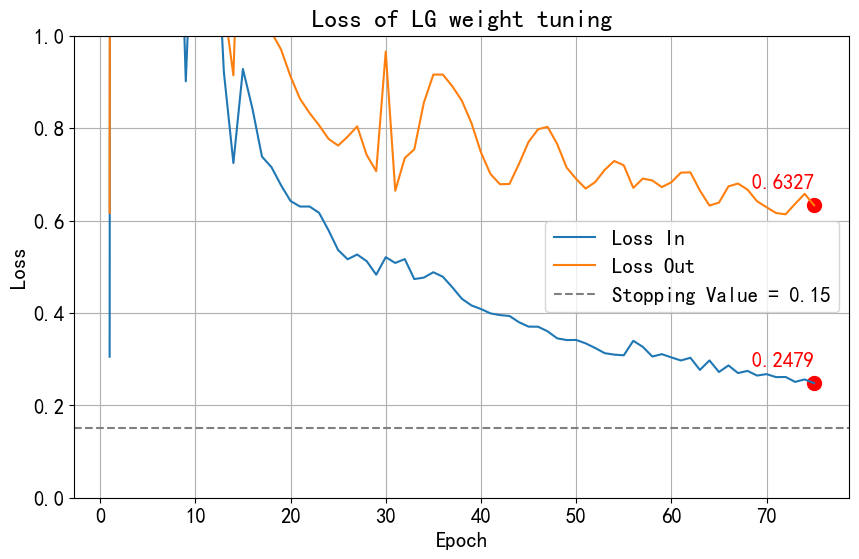

In [204]:
draw_lr_step(loss_in_list,loss_out_list,stopping_error)

0.4635203778743744
9958668288.0


C:\Users\IanKu\AppData\Local\Temp\ipykernel_33068\2668975548.py:6: UserWarning: Using a target size (torch.Size([482])) that is different to the input size (torch.Size([482, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  loss2 = nn.functional.mse_loss(y_pred_val,torch.Tensor.cpu(y_val))


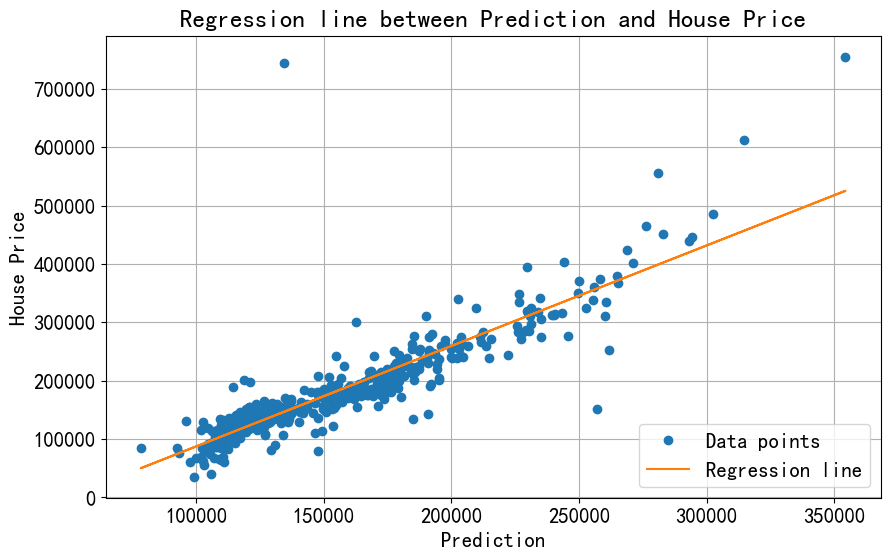

In [205]:
draw_pred_reggsion(model_11,print_error = True)

### 2. weight tuning LG UA  + regularizing_LG UA with l2  loss 

In [45]:
models_LGUA_accept = []
models_LGUA_regulization = []

#### train with LG UA

In [65]:
EB = False
LG = True
UA= True
DO = False
BN = False
l2 = False
regulization = False
initial_lr = 1e-3
stopping_lr = 6e-4
stopping_error = 0.2 if l2 else 0.075
stopping_epochs = 75

loss_in_list, loss_out_list, stopping_error = training(model_11,EB = EB, LG = LG,UA= UA, DO = DO, BN = BN, l2 = l2,
             regulization = regulization,initial_lr = initial_lr, stopping_lr = stopping_lr, stopping_error = stopping_error, stopping_epochs = stopping_epochs)
  
models_LGUA_accept.append(model_11)



1
Epoch 1: Loss In 1.1757738590240479, Loss Out 1.169812798500061, Learning Rate 0.001
Epoch 2: Loss In 1.1459251642227173, Loss Out 1.1515637636184692, Learning Rate 0.00102
Epoch 3: Loss In 1.1164331436157227, Loss Out 1.1337817907333374, Learning Rate 0.0010404000000000001
Epoch 4: Loss In 1.0872023105621338, Loss Out 1.1169768571853638, Learning Rate 0.0010612080000000001
Epoch 5: Loss In 1.057932734489441, Loss Out 1.1003533601760864, Learning Rate 0.0010824321600000002
Epoch 6: Loss In 1.028910756111145, Loss Out 1.0844435691833496, Learning Rate 0.0011040808032000001
Epoch 7: Loss In 1.0002996921539307, Loss Out 1.069342851638794, Learning Rate 0.0011261624192640003
Epoch 8: Loss In 0.9722021222114563, Loss Out 1.0550321340560913, Learning Rate 0.0011486856676492802
Epoch 9: Loss In 0.9448265433311462, Loss Out 1.0415745973587036, Learning Rate 0.0011716593810022658
Epoch 10: Loss In 0.9183592796325684, Loss Out 1.0289586782455444, Learning Rate 0.0011950925686223112
Epoch 11: L

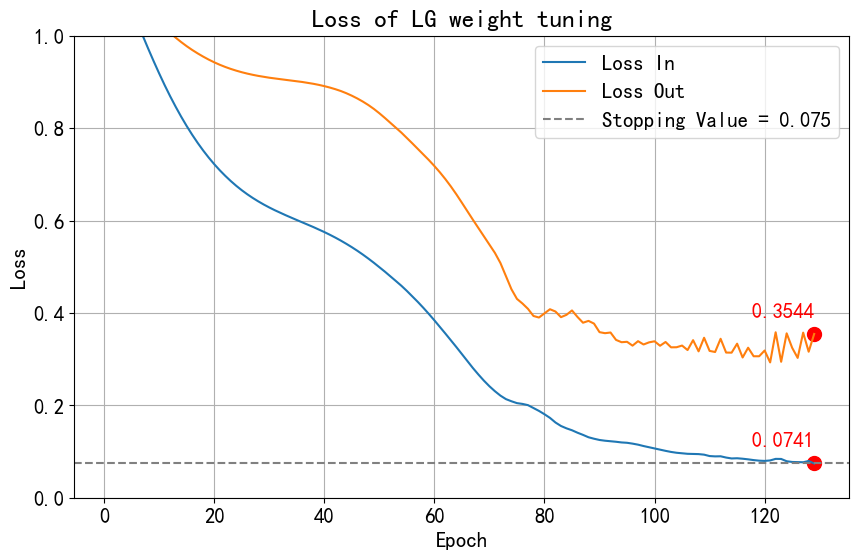

In [66]:
draw_lr_step(loss_in_list,loss_out_list,stopping_error)

0.35443225502967834
10233542656.0


C:\Users\IanKu\AppData\Local\Temp\ipykernel_18020\2668975548.py:6: UserWarning: Using a target size (torch.Size([482])) that is different to the input size (torch.Size([482, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  loss2 = nn.functional.mse_loss(y_pred_val,torch.Tensor.cpu(y_val))


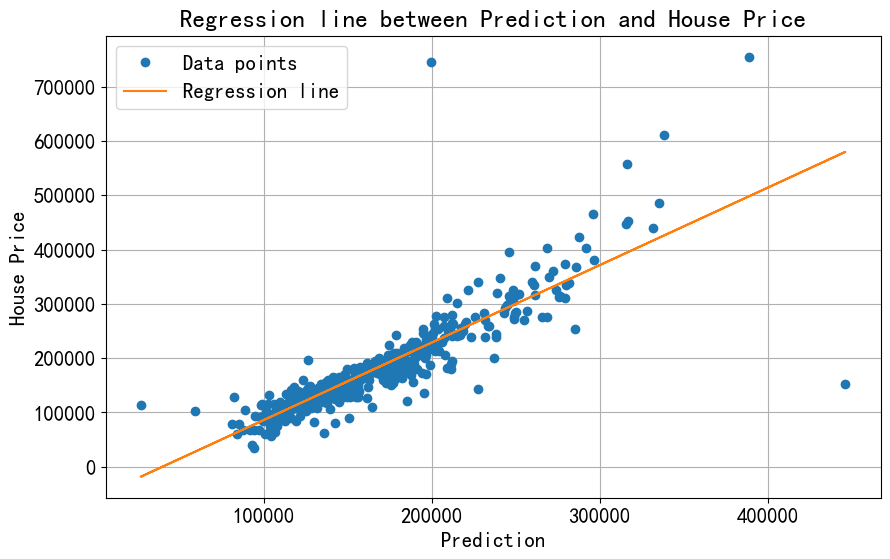

In [67]:
draw_pred_reggsion(model_11,print_error = True)

#### regulization with LG UA l2

In [68]:
EB = False
LG = True
UA= True
DO = False
BN = False
l2 = True
regulization = True
initial_lr = 1e-3
stopping_lr = 6e-4
stopping_error = 0.1 if l2 else 0.05
stopping_epochs = 75

loss_in_list, loss_out_list, stopping_error, model_11 = training(model_11,EB = EB, LG = LG,UA= UA, DO = DO, BN = BN, l2 = l2,
             regulization = regulization,initial_lr = initial_lr, stopping_lr = stopping_lr, stopping_error = stopping_error, stopping_epochs = stopping_epochs)
  
models_LGUA_regulization.append(model_11)

Epoch 1: Loss In 0.2498188018798828, Loss Out 0.5301651954650879, Learning Rate 0.001
update new model
Epoch 2: Loss In 0.24658063054084778, Loss Out 0.4996389150619507, Learning Rate 0.00102
update new model
Epoch 3: Loss In 0.2461213320493698, Loss Out 0.4829653203487396, Learning Rate 0.0010404000000000001
update new model
Epoch 4: Loss In 0.24446812272071838, Loss Out 0.4797724187374115, Learning Rate 0.0010612080000000001
update new model
Epoch 5: Loss In 0.24268576502799988, Loss Out 0.48434367775917053, Learning Rate 0.0010824321600000002
update new model
Epoch 6: Loss In 0.24144169688224792, Loss Out 0.4934988021850586, Learning Rate 0.0011040808032000001
update new model
Epoch 7: Loss In 0.24041616916656494, Loss Out 0.5006582736968994, Learning Rate 0.0011261624192640003
update new model
Epoch 8: Loss In 0.23911555111408234, Loss Out 0.5006821155548096, Learning Rate 0.0011486856676492802
update new model
Epoch 9: Loss In 0.23775555193424225, Loss Out 0.4941466450691223, Lear

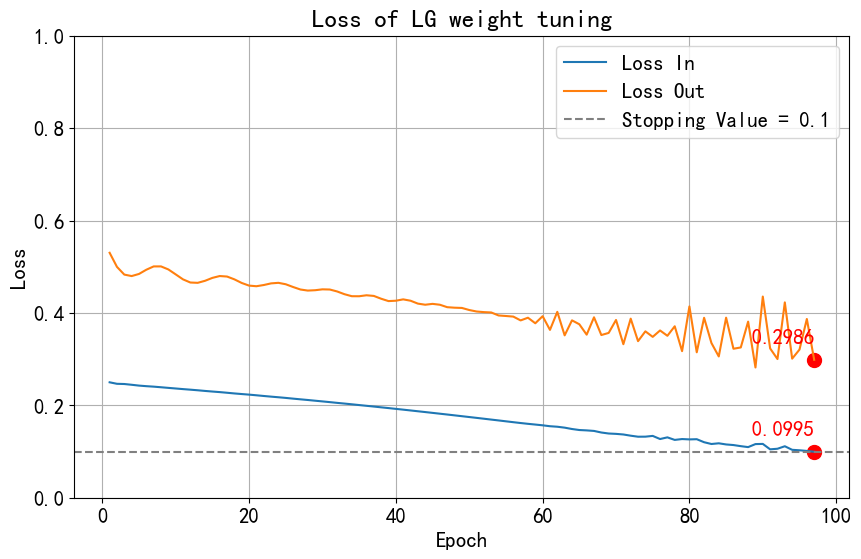

In [69]:
draw_lr_step(loss_in_list,loss_out_list,stopping_error)

0.2510243058204651
11435991040.0


C:\Users\IanKu\AppData\Local\Temp\ipykernel_18020\2668975548.py:6: UserWarning: Using a target size (torch.Size([482])) that is different to the input size (torch.Size([482, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  loss2 = nn.functional.mse_loss(y_pred_val,torch.Tensor.cpu(y_val))


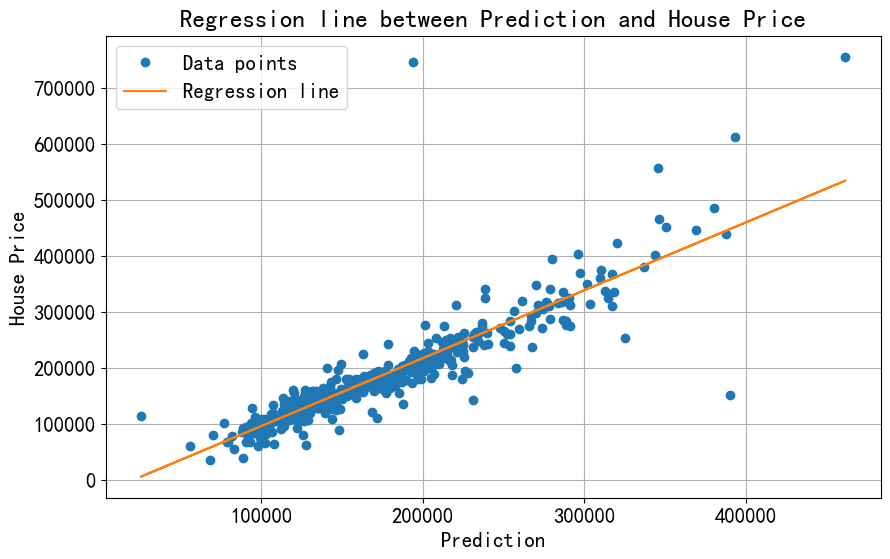

In [70]:
draw_pred_reggsion(model_11,print_error = True)

### 3. weight tuning EB LG UA  + regularizing EB LG UA  with l2  loss 

In [71]:
models_EBLGUA_accept = []
models_EBLGUA_regulization = []

#### train with EB LG UA 

In [72]:
EB = True
LG = True
UA= True
DO = False
BN = False
l2 = False
regulization = False
initial_lr = 1e-3
stopping_lr = 6e-4
stopping_error = 0.15 if l2 else 0.05
stopping_epochs = 100

loss_in_list, loss_out_list, stopping_error = training(model_11,EB = EB, LG = LG,UA= UA, DO = DO, BN = BN, l2 = l2,
             regulization = regulization,initial_lr = initial_lr, stopping_lr = stopping_lr, stopping_error = stopping_error, stopping_epochs = stopping_epochs)
  
models_EBLGUA_accept.append(model_11)



1
Epoch 1: Loss In 1.4276401996612549, Loss Out 1.5052865743637085, Learning Rate 0.001
Epoch 2: Loss In 1.3880255222320557, Loss Out 1.4694892168045044, Learning Rate 0.00102
Epoch 3: Loss In 1.349015235900879, Loss Out 1.4350416660308838, Learning Rate 0.0010404000000000001
Epoch 4: Loss In 1.3108339309692383, Loss Out 1.402029037475586, Learning Rate 0.0010612080000000001
Epoch 5: Loss In 1.2734557390213013, Loss Out 1.3703547716140747, Learning Rate 0.0010824321600000002
Epoch 6: Loss In 1.236990213394165, Loss Out 1.3399379253387451, Learning Rate 0.0011040808032000001
Epoch 7: Loss In 1.2015693187713623, Loss Out 1.3108532428741455, Learning Rate 0.0011261624192640003
Epoch 8: Loss In 1.1672649383544922, Loss Out 1.283155083656311, Learning Rate 0.0011486856676492802
Epoch 9: Loss In 1.13417649269104, Loss Out 1.2568448781967163, Learning Rate 0.0011716593810022658
Epoch 10: Loss In 1.102420449256897, Loss Out 1.2319341897964478, Learning Rate 0.0011950925686223112
Epoch 11: Loss

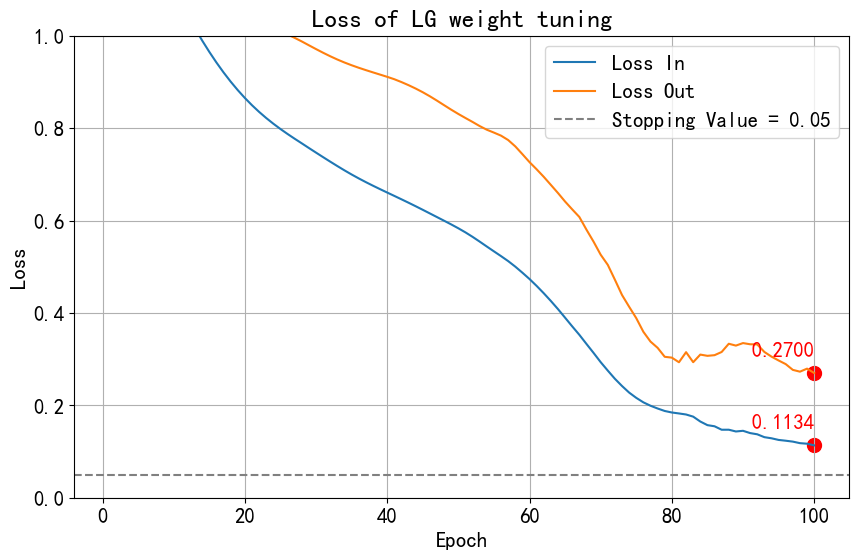

In [73]:
draw_lr_step(loss_in_list,loss_out_list,stopping_error)

0.2674473524093628
10814138368.0


C:\Users\IanKu\AppData\Local\Temp\ipykernel_18020\2668975548.py:6: UserWarning: Using a target size (torch.Size([482])) that is different to the input size (torch.Size([482, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  loss2 = nn.functional.mse_loss(y_pred_val,torch.Tensor.cpu(y_val))


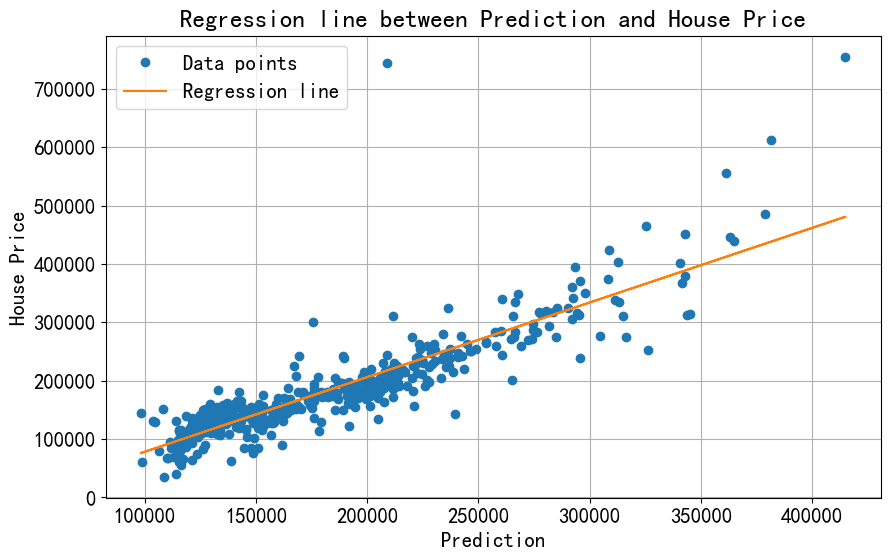

In [74]:
draw_pred_reggsion(model_11,print_error = True)

#### regulization with EB LG UA l2

In [75]:
EB = True
LG = True
UA= True
DO = False
BN = False
l2 = True
regulization = True
initial_lr = 1e-3
stopping_lr = 6e-4
stopping_error = 0.1 if l2 else 0.05
stopping_epochs = 75

loss_in_list, loss_out_list, stopping_error, model_11 = training(model_11,EB = EB, LG = LG,UA= UA, DO = DO, BN = BN, l2 = l2,
             regulization = regulization,initial_lr = initial_lr, stopping_lr = stopping_lr, stopping_error = stopping_error, stopping_epochs = stopping_epochs)
  
models_EBLGUA_regulization.append(model_11)

Epoch 1: Loss In 0.21635320782661438, Loss Out 0.37264007329940796, Learning Rate 0.001
update new model
Epoch 2: Loss In 0.2165393829345703, Loss Out 0.3843781054019928, Learning Rate 0.00102
update new model
Epoch 3: Loss In 0.21249651908874512, Loss Out 0.37800854444503784, Learning Rate 0.0010404000000000001
update new model
Epoch 4: Loss In 0.21078169345855713, Loss Out 0.3741706311702728, Learning Rate 0.0010612080000000001
update new model
Epoch 5: Loss In 0.21039852499961853, Loss Out 0.37451744079589844, Learning Rate 0.0010824321600000002
update new model
Epoch 6: Loss In 0.20837685465812683, Loss Out 0.37400656938552856, Learning Rate 0.0011040808032000001
update new model
Epoch 7: Loss In 0.20596259832382202, Loss Out 0.3739142417907715, Learning Rate 0.0011261624192640003
update new model
Epoch 8: Loss In 0.20449954271316528, Loss Out 0.3752441704273224, Learning Rate 0.0011486856676492802
update new model
Epoch 9: Loss In 0.2033511996269226, Loss Out 0.3753679096698761, L

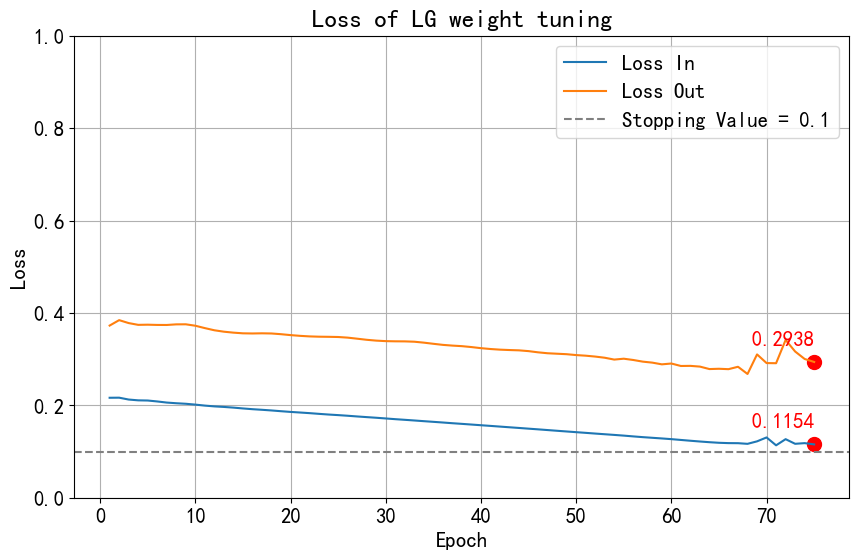

In [76]:
draw_lr_step(loss_in_list,loss_out_list,stopping_error)

C:\Users\IanKu\AppData\Local\Temp\ipykernel_18020\2668975548.py:6: UserWarning: Using a target size (torch.Size([482])) that is different to the input size (torch.Size([482, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  loss2 = nn.functional.mse_loss(y_pred_val,torch.Tensor.cpu(y_val))


0.25985798239707947
10604532736.0


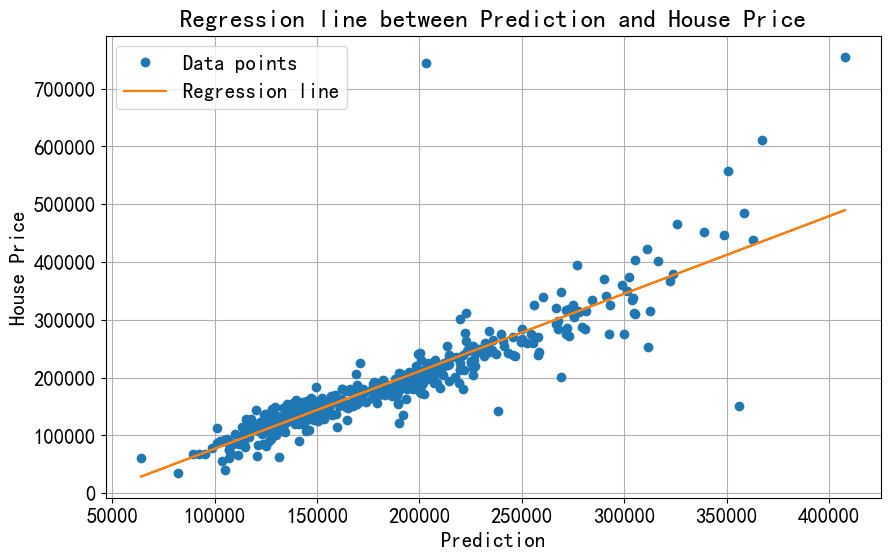

In [77]:
draw_pred_reggsion(model_11,print_error = True)

### 4. weight tuning EB   + regularizing EB DO

In [78]:
models_EBDO_accept = []
models_EBDO_regulization = []

#### train with EB 

In [79]:
EB = True
LG = False
UA= False
DO = False
BN = False
l2 = False
regulization = False
initial_lr = 1e-3
stopping_lr = 6e-4
stopping_error = 0.1 if l2 else 0.05
stopping_epochs = 75

loss_in_list, loss_out_list, stopping_error = training(model_11,EB = EB, LG = LG,UA= UA, DO = DO, BN = BN, l2 = l2,
             regulization = regulization,initial_lr = initial_lr, stopping_lr = stopping_lr, stopping_error = stopping_error, stopping_epochs = stopping_epochs)
  
models_EBDO_accept.append(model_11)



1
Epoch 1: Loss In 1.3907244205474854, Loss Out 1.4293617010116577, Learning Rate 0.001
Epoch 2: Loss In 1.3625952005386353, Loss Out 1.40305495262146, Learning Rate 0.001
Epoch 3: Loss In 1.3354096412658691, Loss Out 1.3782461881637573, Learning Rate 0.001
Epoch 4: Loss In 1.309281826019287, Loss Out 1.354809045791626, Learning Rate 0.001
Epoch 5: Loss In 1.2841562032699585, Loss Out 1.332709550857544, Learning Rate 0.001
Epoch 6: Loss In 1.2600773572921753, Loss Out 1.3119499683380127, Learning Rate 0.001
Epoch 7: Loss In 1.2368147373199463, Loss Out 1.2923901081085205, Learning Rate 0.001
Epoch 8: Loss In 1.214375615119934, Loss Out 1.2739388942718506, Learning Rate 0.001
Epoch 9: Loss In 1.1927741765975952, Loss Out 1.2565149068832397, Learning Rate 0.001
Epoch 10: Loss In 1.1719496250152588, Loss Out 1.2400530576705933, Learning Rate 0.001
Epoch 11: Loss In 1.151780128479004, Loss Out 1.2244939804077148, Learning Rate 0.001
Epoch 12: Loss In 1.1322638988494873, Loss Out 1.20976662

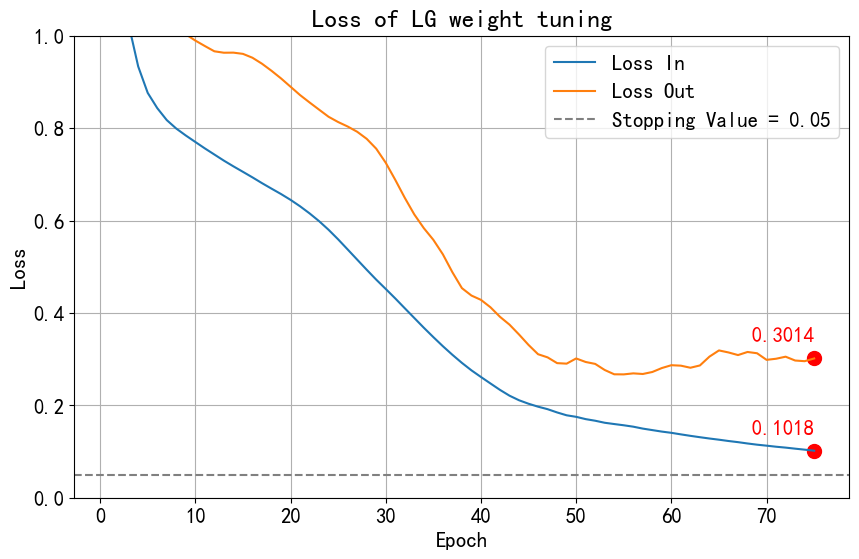

In [102]:
draw_lr_step(loss_in_list,loss_out_list,stopping_error)

0.30411389470100403
12822299648.0


C:\Users\IanKu\AppData\Local\Temp\ipykernel_24792\2668975548.py:6: UserWarning: Using a target size (torch.Size([482])) that is different to the input size (torch.Size([482, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  loss2 = nn.functional.mse_loss(y_pred_val,torch.Tensor.cpu(y_val))


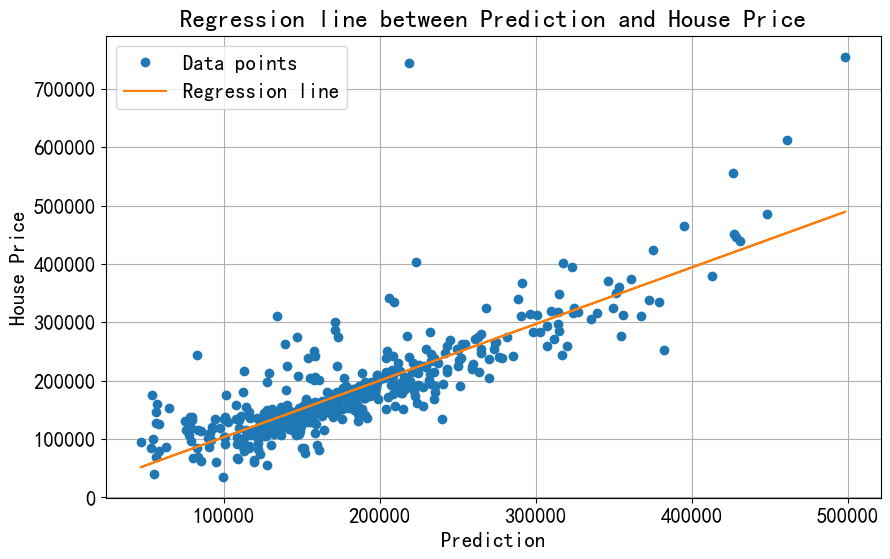

In [103]:
draw_pred_reggsion(model_11,print_error = True)

#### regulization with EB DO

In [104]:
EB = True
LG = False
UA= False
DO = True
BN = False
l2 = False
regulization = True
initial_lr = 1e-3
stopping_lr = 6e-4
stopping_error = 0.1 if l2 else 0.05
stopping_epochs = 75

loss_in_list, loss_out_list, stopping_error, model_11 = training(model_11,EB = EB, LG = LG,UA= UA, DO = DO, BN = BN, l2 = l2,
             regulization = regulization,initial_lr = initial_lr, stopping_lr = stopping_lr, stopping_error = stopping_error, stopping_epochs = stopping_epochs)
  
models_EBDO_regulization.append(model_11)

Epoch 1: Loss In 0.6421376466751099, Loss Out 0.30411389470100403, Learning Rate 0.001
update new model
Epoch 2: Loss In 0.5471259951591492, Loss Out 0.4886404871940613, Learning Rate 0.001
update new model
Epoch 3: Loss In 0.5565440058708191, Loss Out 0.6077987551689148, Learning Rate 0.001
update new model
Epoch 4: Loss In 0.4385630488395691, Loss Out 0.548787534236908, Learning Rate 0.001
update new model
Epoch 5: Loss In 0.5039022564888, Loss Out 0.4970521628856659, Learning Rate 0.001
update new model
Epoch 6: Loss In 0.468938946723938, Loss Out 0.42838090658187866, Learning Rate 0.001
update new model
Epoch 7: Loss In 0.4051414430141449, Loss Out 0.4081907868385315, Learning Rate 0.001
update new model
Epoch 8: Loss In 0.47026100754737854, Loss Out 0.4011361002922058, Learning Rate 0.001
update new model
Epoch 9: Loss In 0.47894272208213806, Loss Out 0.38694238662719727, Learning Rate 0.001
update new model
Epoch 10: Loss In 0.4162043035030365, Loss Out 0.3670252859592438, Learni

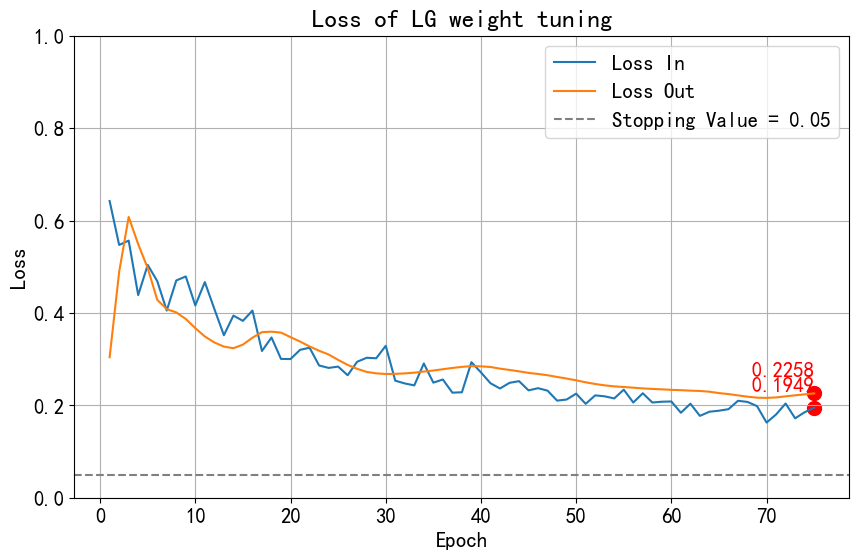

In [105]:
draw_lr_step(loss_in_list,loss_out_list,stopping_error)

0.22903701663017273
12126996480.0


C:\Users\IanKu\AppData\Local\Temp\ipykernel_24792\2668975548.py:6: UserWarning: Using a target size (torch.Size([482])) that is different to the input size (torch.Size([482, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  loss2 = nn.functional.mse_loss(y_pred_val,torch.Tensor.cpu(y_val))


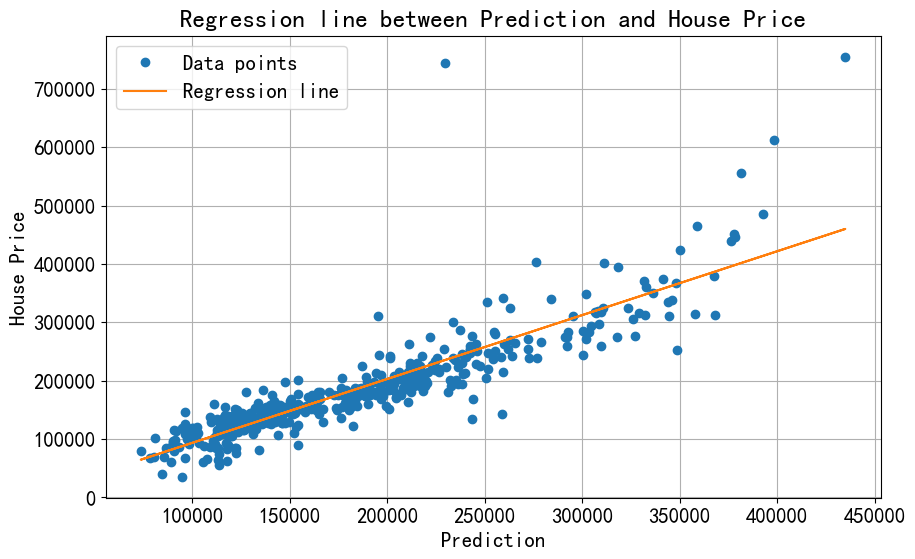

In [106]:
draw_pred_reggsion(model_11,print_error = True)

### 5. weight tuning EB   + regularizing EB DO

In [107]:
models_EBBN_accept = []
models_EBBN_regulization = []

#### train with EB 

In [108]:
EB = True
LG = False
UA= False
DO = False
BN = False
l2 = False
regulization = False
initial_lr = 1e-3
stopping_lr = 6e-4
stopping_error = 0.1 if l2 else 0.05
stopping_epochs = 75

loss_in_list, loss_out_list, stopping_error = training(model_11,EB = EB, LG = LG,UA= UA, DO = DO, BN = BN, l2 = l2,
             regulization = regulization,initial_lr = initial_lr, stopping_lr = stopping_lr, stopping_error = stopping_error, stopping_epochs = stopping_epochs)
  
models_EBBN_accept.append(model_11)



Epoch 1: Loss In 1.9861416816711426, Loss Out 2.307358503341675, Learning Rate 0.001
Epoch 2: Loss In 1.852182149887085, Loss Out 2.176486015319824, Learning Rate 0.001
Epoch 3: Loss In 1.7492300271987915, Loss Out 2.081301212310791, Learning Rate 0.001
Epoch 4: Loss In 1.6674680709838867, Loss Out 1.9975229501724243, Learning Rate 0.001
Epoch 5: Loss In 1.6073306798934937, Loss Out 1.9411717653274536, Learning Rate 0.001
Epoch 6: Loss In 1.5644303560256958, Loss Out 1.911637783050537, Learning Rate 0.001
Epoch 7: Loss In 1.5239918231964111, Loss Out 1.877960205078125, Learning Rate 0.001
Epoch 8: Loss In 1.4837334156036377, Loss Out 1.837769865989685, Learning Rate 0.001
Epoch 9: Loss In 1.4441288709640503, Loss Out 1.7885725498199463, Learning Rate 0.001
Epoch 10: Loss In 1.4060287475585938, Loss Out 1.7357048988342285, Learning Rate 0.001
Epoch 11: Loss In 1.370495080947876, Loss Out 1.6818968057632446, Learning Rate 0.001
Epoch 12: Loss In 1.3403751850128174, Loss Out 1.63376033306

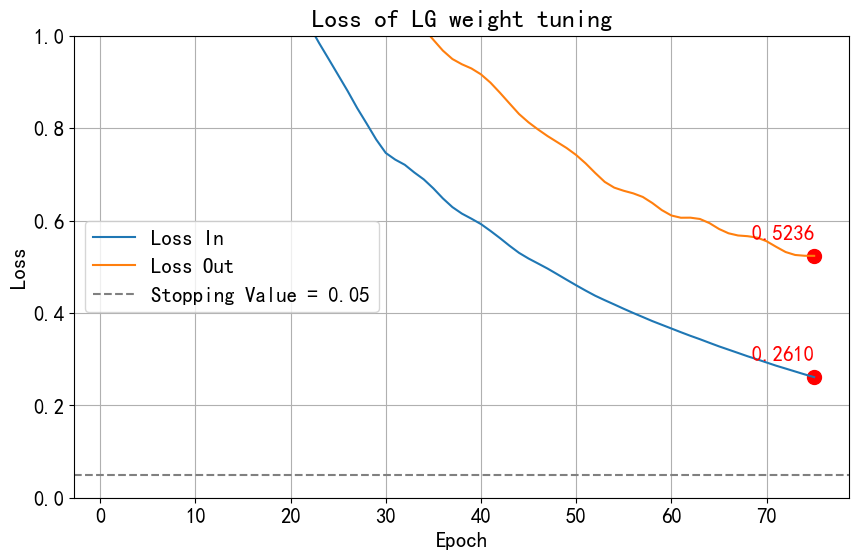

In [109]:
draw_lr_step(loss_in_list,loss_out_list,stopping_error)

0.5166227221488953
10200172544.0


C:\Users\IanKu\AppData\Local\Temp\ipykernel_24792\2668975548.py:6: UserWarning: Using a target size (torch.Size([482])) that is different to the input size (torch.Size([482, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  loss2 = nn.functional.mse_loss(y_pred_val,torch.Tensor.cpu(y_val))


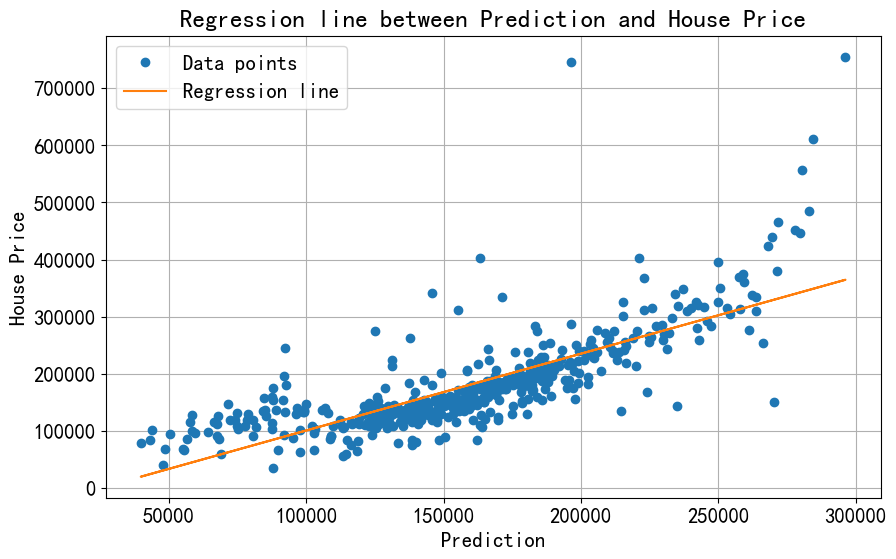

In [110]:
draw_pred_reggsion(model_11,print_error = True)

#### regulization with EB DO

In [113]:
EB = True
LG = False
UA= False
DO = False
BN = True
l2 = False
regulization = True
initial_lr = 1e-3
stopping_lr = 6e-4
stopping_error = 0.1 if l2 else 0.05
stopping_epochs = 50

loss_in_list, loss_out_list, stopping_error, model_11 = training(model_11,EB = EB, LG = LG,UA= UA, DO = DO, BN = BN, l2 = l2,
             regulization = regulization,initial_lr = initial_lr, stopping_lr = stopping_lr, stopping_error = stopping_error, stopping_epochs = stopping_epochs)
  
models_EBBN_regulization.append(model_11)

Epoch 1: Loss In 0.03298895061016083, Loss Out 0.5043054223060608, Learning Rate 0.001
update new model
Epoch 2: Loss In 0.22212207317352295, Loss Out 0.7814711332321167, Learning Rate 0.001
update new model
Epoch 3: Loss In 0.11840333789587021, Loss Out 0.4219760000705719, Learning Rate 0.001
update new model
Epoch 4: Loss In 0.09133898466825485, Loss Out 0.3173542618751526, Learning Rate 0.001
update new model
Epoch 5: Loss In 0.06582712382078171, Loss Out 0.3204265534877777, Learning Rate 0.001
update new model
Epoch 6: Loss In 0.08654137700796127, Loss Out 0.3772296905517578, Learning Rate 0.001
update new model
Epoch 7: Loss In 0.08780194073915482, Loss Out 0.37849104404449463, Learning Rate 0.001
update new model
Epoch 8: Loss In 0.07051976770162582, Loss Out 0.3411061465740204, Learning Rate 0.001
update new model
Epoch 9: Loss In 0.06072121486067772, Loss Out 0.3043966293334961, Learning Rate 0.001
update new model
Epoch 10: Loss In 0.0590682327747345, Loss Out 0.29634559154510

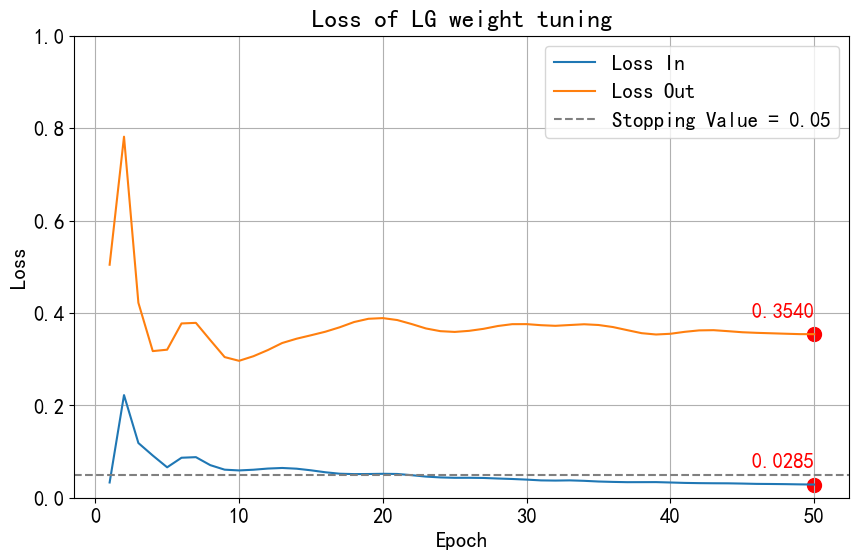

In [114]:
draw_lr_step(loss_in_list,loss_out_list,stopping_error)

0.3556588888168335
11841227776.0


C:\Users\IanKu\AppData\Local\Temp\ipykernel_24792\2668975548.py:6: UserWarning: Using a target size (torch.Size([482])) that is different to the input size (torch.Size([482, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  loss2 = nn.functional.mse_loss(y_pred_val,torch.Tensor.cpu(y_val))


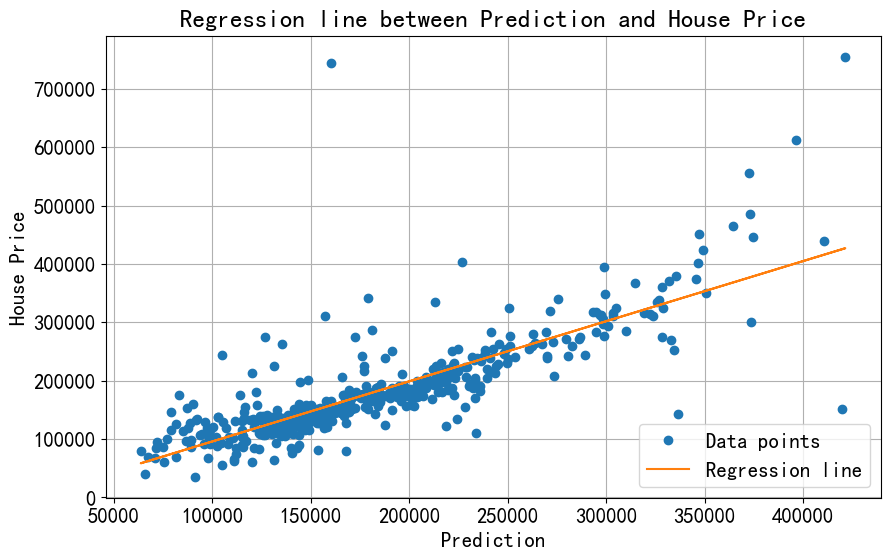

In [115]:
draw_pred_reggsion(model_11,print_error = True)

## Conclusion
#### HW4Update 
#### 1.這次把程式整個大改，把訓練與regulization分開，並且寫成一個訓練的函數，可以選擇是否要EB、LG、UA、DO、BN以及調整訓練模式與regulization模式，雖然最後的code在LG+UA的地方和老師有些差異(老師的LG判定放在迴圈最後，我把LG放在forward後面)，但結果看下來是好的。
#### 2.將訓練與regulization分開後，訓練成本大幅下降，從原本50000步左右變成大約75步，應該是因為加上l2後損失函數圖形變得太複雜，以及沒有l2的話超過75步後容易overfitting導致。一開始把l2丟掉時沒有發現overfitting，等到後來發現model 有訓練模式與評估模式，才發現超級大過擬。
#### 3.小問題，DO layer加上去後拿來做UA的ReduceLROnPlateau就失效了，不管loss 多大lr就是不會變，網路上也找不到相關的議題，可能需要跟老師憶起研究一下。

##### HW3Update 這次加上了顯卡支援跑到了大約50000 epochs 左右，效果也稍微有提升，我發現torch 套件的 torch.optim.lr_scheduler 的 ReduceLROnPlateau 就是在做UA的部分

##### HW2update 這次一開始調了一堆參數增加了好幾層但最後結果都不太理想，後來發現一個問題是我Xavier函數沒寫好，幾乎等於沒做，補好之後發現生出來的數字可以調整scale。另一點模型表現增加最多的地方是對y做了scale，用robust scaler 調整並用來訓練，訓練完後再把test 預測出來的結果用inverse_transform轉換回去。

## hidden nodes:
#### 6 layer 改成 4layer  214 100 50 11 1 
## initial weight:
#### Xavier 
## Activation:
#### 主要用LeakyRELU
## Loss:
#### MSE ,把 l2 regulization 去掉後從50000步降到75步...
## Optmizer epoch
#### Adam 
## learning_rate
#### 起始值設10^-3, UA停止值設 6^10-4, 用ReduceLROnPlateau做UA learn rate decay, loss > 0.1時 lr大概在10^-6 上下，到10^-7左右時跑的超慢
## learn rate scheduler
#### 用ReduceLROnPlateau做UA, 每次變成0.9倍, loss 5輪沒降才會調, 停止值設 6^10-4
## DO
#### 每層被丟掉ˋ的機率都是0.1
## BN
#### 做的是BatchNorm1d，不確定和BatchNorm2d有什麼差別
## Ensembles
#### 下次一定做

